In [ ]:
# Standard Library
import os
import subprocess
import zipfile
from pathlib import Path

# Data Handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Audio Processing
import librosa

# Machine Learning & Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE

# Utilities
from tqdm import tqdm

# Deep Learning Project: Bird Species Classification from Audio Recordings

##  Deep Learning Problem Definition

The goal of this project is to build a deep learning model that can **predict the bird species** based on the audio recording of its song. This is a supervised **multi-class classification** problem with 114 possible classes.

### Problem Type
- **Task**: Supervised Deep Learning
- **Input**: mp3 audio recordings of birds
- **Output**: Predicted bird species label
- **Model Type**: Convolutional Neural Networks (CNNs), Recurrent Neural Networks (RNNs) with attention mechanisms, and a hybryd of both.


## Dataset Description

The dataset used for this project is Sound of 114 Species of Birds till 2022, which contains MP3 recordings of bird songs from 114 different species. Each audio file represents a unique instance of bird vocalization. The accompanying CSV file was not used, as it did not contain matching or usable metadata for the MP3 files.

- **Data Type**: Audio (MP3 format)
- **Labels**: Bird species (inferred from file names or folder structure)
- **Size**: ~8.5 GB of audio data, 2144 individual recordeings before augumnetation
-No structured metadata; requires parsing filenames or directory structure for labels

## Audio Preprocessing Strategy

Given the large size and unstructured nature of the dataset (over 8 GB of MP3 files across 114 bird species), a robust and scalable preprocessing pipeline was essential. The goal was to convert raw audio into a format suitable for deep learning models while maintaining flexibility for iterative development. When developing the pipline, the requiremnts for CNN models was prioritized. 

### Conversion and Normalization

1. **MP3 to WAV Conversion**  
   MP3 files were converted to WAV format using `ffmpeg` to ensure compatibility with `librosa`, a Python library for audio analysis. WAV files preserve raw waveform data and are easier to manipulate for feature extraction.

2. **Trimming Silence and Normalization**  
   Using `librosa.effects.trim`, leading and trailing silence was removed to focus on the actual bird vocalizations. The audio was then normalized to ensure consistent amplitude across samples, which helps reduce model bias toward louder recordings.

3. **Mel Spectrogram Extraction**  
   Each waveform was transformed into a Mel spectrogram—a time-frequency representation that mimics human auditory perception. This 2D representation is ideal for convolutional neural networks (CNNs), which excel at learning spatial patterns.

### Iterative Dataset Creation

Due to the dataset's size and the computational cost of processing all files at once, I adopted an **iterative strategy**:
- Spectrograms were saved as `.npy` files and zipped into a single archive.
- A metadata CSV was created to track species, original audio file names, augmentation types, and spectrogram paths.
- This allowed me to reload and work with a preprocessed dataset in future sessions without repeating expensive operations.

This modular approach enabled efficient experimentation and model training while keeping storage and memory usage manageable.

## Data Augmentation Strategy

Bird vocalizations are highly variable and sensitive to environmental noise, recording conditions, and individual differences. To improve model generalization and robustness, I applied several **audio augmentation techniques**:

### Augmentation Techniques

1. **Pitch Shifting**  
   Simulates variations in vocal pitch due to age, species differences, or recording artifacts.

2. **Time Stretching**  
   Alters the tempo without changing pitch, mimicking natural variations in song speed.

3. **Noise Injection**  
   Adds Gaussian noise to simulate background sounds like wind, insects, or overlapping bird calls.

Each augmented waveform was converted into a Mel spectrogram and treated as a separate training sample. This effectively increased the dataset size and diversity, helping the model learn more robust features and reducing overfitting.

In [ ]:


# Define the conversion function using ffmpeg
def convert_with_ffmpeg(mp3_path, dest_dir):
    """
    Converts an MP3 file to WAV format using ffmpeg.

    Args:
        mp3_path (Path): Path to the input MP3 file.
        dest_dir (Path): Directory to save the converted WAV file.

    Returns:
        Path: Path to the converted WAV file.
    """
    base_name = mp3_path.stem.replace(" ", "_").replace("-", "_")
    wav_path = dest_dir / f"{base_name}.wav"
    ffmpeg_command = f"ffmpeg -y -i \"{mp3_path}\" -acodec pcm_s16le \"{wav_path}\""
    subprocess.run(ffmpeg_command, shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    return wav_path

# Preprocessing and augmentation functions
def preprocess_audio(wav_path, sr=22050):
    """
    Loads, trims, and normalizes an audio file.

    Args:
        wav_path (Path): Path to the WAV audio file.
        sr (int): Target sampling rate.

    Returns:
        np.ndarray: Preprocessed audio waveform.
    """
    y, _ = librosa.load(wav_path, sr=sr)
    y_trimmed, _ = librosa.effects.trim(y)
    y_normalized = librosa.util.normalize(y_trimmed)
    return y_normalized

def extract_mel_spectrogram(y, sr=22050, n_mels=128):
    """
    Extracts a Mel spectrogram from an audio waveform.

    Args:
        y (np.ndarray): Audio waveform.
        sr (int): Sampling rate.
        n_mels (int): Number of Mel bands to generate.

    Returns:
        np.ndarray: Mel spectrogram in dB scale (2D array: n_mels x time_frames).
                    If you need a 1D array, add `.flatten()` before returning.
    """
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

def augment_audio(y, sr):
    """
    Applies various audio augmentations.

    Args:
        y (np.ndarray): Audio waveform.
        sr (int): Sampling rate.

    Returns:
        dict: Dictionary of augmented waveforms, keyed by augmentation type.
    """
    y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)
    y_stretch = librosa.effects.time_stretch(y, rate=1.2)
    noise = np.random.normal(0, 0.005, len(y))
    y_noise = y + noise
    return {
        "pitch_shifted": y_pitch,
        "time_stretched": y_stretch,
        "noise_added": y_noise
    }

# Main pipeline
def process_dataset(dataset_path, output_csv, spec_output_dir="./spectrograms", temp_dir="./temp_wav_files"):
    """
    Processes audio files, extracts spectrograms, applies augmentations,
    saves spectrograms as .npy files, zips them, and creates a metadata CSV.

    Args:
        dataset_path (str): Path to the root directory of your dataset
        output_csv (str): Path where the final CSV metadata file will be saved.
        spec_output_dir (str): Directory where the .npy spectrogram files will be saved temporarily
                               before zipping.
        temp_dir (str): Temporary directory for converted WAV files.
    """
    dataset_path = Path(dataset_path)
    temp_dir = Path(temp_dir)
    spec_output_dir = Path(spec_output_dir)

    # Create necessary directories
    temp_dir.mkdir(exist_ok=True)
    spec_output_dir.mkdir(exist_ok=True, parents=True) 

    data = [] # This list will hold dictionaries for each row in the DataFrame
    npy_files_to_zip = [] # To keep track of all generated .npy files

    # Get all species directories
    species_dirs = [d for d in dataset_path.iterdir() if d.is_dir()]

    if not species_dirs:
        print(f"No species directories found in {dataset_path}. Please check the path.")
        return

    # Process ALL species folders, with progress bar only for folders
    for species_dir in tqdm(species_dirs, desc="Processing species folders"):
        species = species_dir.name
        mp3_files = list(species_dir.glob("*.mp3"))

   
        for mp3_file in mp3_files:
            try:
                # 1. Convert MP3 to WAV
                wav_path = convert_with_ffmpeg(mp3_file, temp_dir)

                # 2. Preprocess audio
                y = preprocess_audio(wav_path)
                sr = 22050 # Consistent sampling rate

                # 3. Extract Mel Spectrogram (Original)
                mel_original = extract_mel_spectrogram(y, sr)
                
                # Define a unique filename for the spectrogram
                original_filename_stem = mp3_file.stem.replace(" ", "_").replace("-", "_")
                spec_filename_original = f"{species}_{original_filename_stem}_original.npy"
                spec_path_original = spec_output_dir / spec_filename_original
                
                # Save the NumPy array to a .npy file
                np.save(spec_path_original, mel_original)
                npy_files_to_zip.append(spec_path_original)
                
                # Add metadata to our data list
                data.append({
                    "species": species,
                    "original_audio_file": str(mp3_file.name),
                    "spectrogram_path_in_zip": spec_filename_original, # Store name within zip
                    "augmentation_type": "original"
                })

                # 4. Augment Audio and Extract Spectrograms for Augmentations
                augmented_waveforms = augment_audio(y, sr)
                for aug_type, y_aug in augmented_waveforms.items():
                    mel_aug = extract_mel_spectrogram(y_aug, sr)
                    
                    # Define unique filename for augmented spectrogram
                    spec_filename_aug = f"{species}_{original_filename_stem}_{aug_type}.npy"
                    spec_path_aug = spec_output_dir / spec_filename_aug
                    
                    # Save the augmented NumPy array
                    np.save(spec_path_aug, mel_aug)
                    npy_files_to_zip.append(spec_path_aug)
                    
                    # Add metadata for augmented data
                    data.append({
                        "species": species,
                        "original_audio_file": str(mp3_file.name),
                        "spectrogram_path_in_zip": spec_filename_aug, # Store name within zip
                        "augmentation_type": aug_type
                    })

                # Clean up temporary WAV file
                os.remove(wav_path)

            except Exception as e:
                print(f"Error processing {mp3_file.name} (Species: {species}): {e}")
                

    # Create DataFrame from collected data
    df = pd.DataFrame(data)
    
    # Save the DataFrame to CSV
    df.to_csv(output_csv, index=False)
    
    # Zip all .npy files 
    zip_filename = Path(f"{spec_output_dir.name}.zip") # Zip file will be created in current working directory
                                                       
    print(f"\nZipping {len(npy_files_to_zip)} spectrogram files into {zip_filename}...")
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for npy_file_path in tqdm(npy_files_to_zip, desc="Compressing .npy files"):
            # Add file to zip, using just its name inside the archive
            zipf.write(npy_file_path, arcname=npy_file_path.name)
    print("Zipping complete.")

dataset_input_path = "/kaggle/input/sound-of-114-species-of-birds-till-2022/Voice of Birds/Voice of Birds"
output_csv_file = "birdsong_metadata_full.csv"
# This will be the temporary folder where .npy files are stored before zipping
spectrogram_temp_npy_dir = "./temp_bird_spectrograms_npy" 
final_zip_name = "temp_bird_spectrograms_npy.zip" # This is derived from `spec_output_dir.name`

# Run the processing pipeline
process_dataset(dataset_input_path, output_csv_file, spectrogram_temp_npy_dir)



### Re-loading the dataset

The following code snipet was used to re-load the processed dataset at the start each working iteration.

In [ ]:

# Load metadata CSV
csv_path = "/kaggle/input/bird-processed-sounds/birdsong_metadata_full.csv"
spec_dir = "/kaggle/input/bird-processed-sounds/proccessed_spectrograms/kaggle/temp/temp_bird_spectrograms_npy"

# Load the metadata DataFrame
df = pd.read_csv(csv_path)

# Filter out species with fewer than 8 samples to ensure sufficient data for analysis
species_counts = df['species'].value_counts()
valid_species = species_counts[species_counts >= 8].index
df = df[df['species'].isin(valid_species)].reset_index(drop=True)

# Function to load spectrograms and ensure they have the target shape (128, 128, 1)
def load_and_fix_shape(path, target_shape=(128, 128)):
    """
    Loads a spectrogram from a .npy file, reshapes it to the target_shape,
    pads or truncates if necessary, and adds a channel dimension.

    Args:
        path (str): The full path to the .npy spectrogram file.
        target_shape (tuple): The desired 2D shape (e.g., (128, 128)).

    Returns:
        np.ndarray: The processed spectrogram with shape (target_shape[0], target_shape[1], 1),
                    or None if an error occurs or the shape is incompatible.
    """
    try:
        spec = np.load(path)

        # Handle 1D arrays: assume it's a flattened spectrogram
        if spec.ndim == 1:
            if spec.size == target_shape[0] * target_shape[1]:
                spec = spec.reshape(target_shape)
            else:
                print(f"Warning: 1D spectrogram {path} has unexpected size {spec.size}. Skipping.")
                return None
        # Handle 2D arrays: typical spectrogram shape (freq, time)
        elif spec.ndim == 2:
            # Ensure the first dimension (frequency bins) matches target_shape[0]
            if spec.shape[0] != target_shape[0]:
                # If not, try transposing if the second dimension matches target_shape[0]
                if spec.shape[1] == target_shape[0]:
                    spec = spec.T # Transpose to get (128, X)
                else:
                    print(f"Warning: Spectrogram {path} has unexpected shape {spec.shape}. Skipping.")
                    return None

            # Pad or truncate the second dimension (time frames) to target_shape[1]
            if spec.shape[1] < target_shape[1]:
                pad_width = target_shape[1] - spec.shape[1]
                spec = np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')
            elif spec.shape[1] > target_shape[1]:
                spec = spec[:, :target_shape[1]]
        else:
            print(f"Warning: Spectrogram {path} has unexpected number of dimensions {spec.ndim}. Skipping.")
            return None

        # Add a channel dimension (e.g., for grayscale images)
        return spec[..., np.newaxis]
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

# Apply the loading and reshaping function to create the 'spectrogram' column
df['spectrogram'] = df['spectrogram_path_in_zip'].apply(
    lambda x: load_and_fix_shape(os.path.join(spec_dir, x))
)

# Remove rows where spectrogram loading failed
df = df.dropna(subset=['spectrogram']).reset_index(drop=True)

# Compute summary statistics for each spectrogram
df['mean_intensity'] = df['spectrogram'].apply(np.mean)
df['std_intensity'] = df['spectrogram'].apply(np.std)
df['max_intensity'] = df['spectrogram'].apply(np.max)
df['min_intensity'] = df['spectrogram'].apply(np.min)

## Exploratory Data Analysis

This section presents an exploratory analysis of the bird song dataset. The dataset includes both original and augmented spectrogram samples, increasing the total number of instances from approximately 2,000 to over 8,000. Augmentation techniques included pitch shifting, time stretching, and noise addition.

### Original and Augmented Sample Breakdown
The following visualizations show the distribution of original and augmented samples across species. The matrix highlights the top species and their augmentation types, while the stacked bar chart provides a broader view.

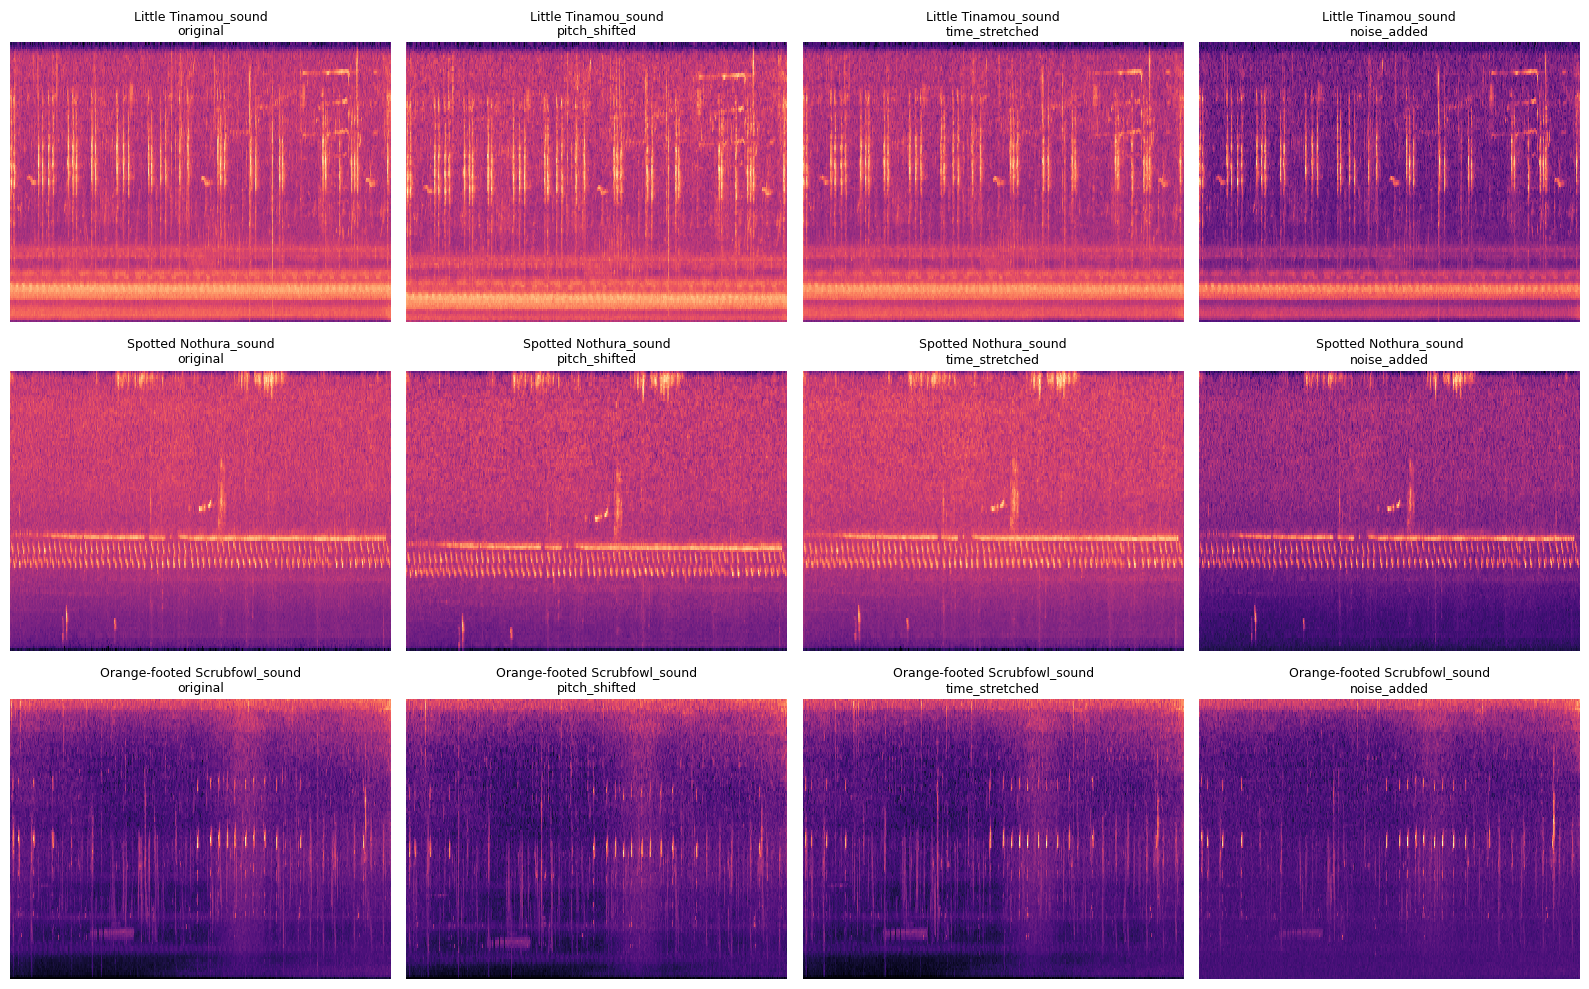

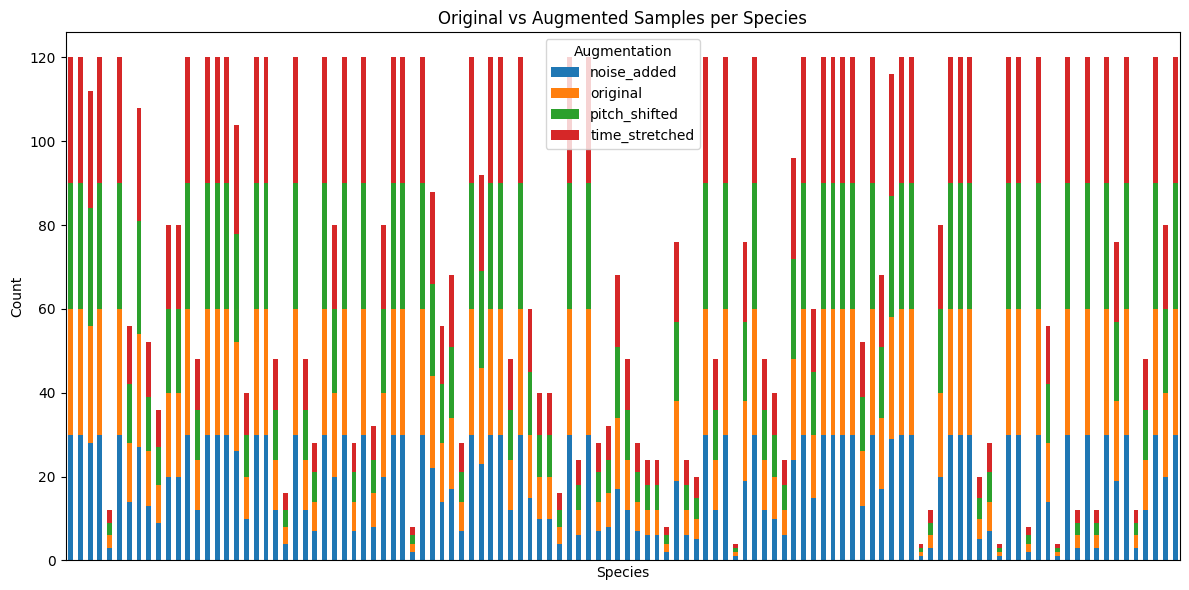

In [5]:
# Matrix of top species and augmentations
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
for i, species in enumerate(top3_species):
    for j, aug in enumerate(augmentations):
        ax = axes[i, j]
        subset = df[(df['species'] == species) & (df['augmentation_type'] == aug)]
        if not subset.empty:
            spec = subset.iloc[0]['spectrogram']
            if spec.ndim == 1:
                spec = spec.reshape(128, -1)
            elif spec.shape[0] != 128:
                if spec.shape[0] > 128:
                    spec = spec[:128, :]
                else:
                    pad_width = 128 - spec.shape[0]
                    spec = np.pad(spec, ((0, pad_width), (0, 0)), mode='constant')
            sns.heatmap(spec, ax=ax, cmap='magma', cbar=False)
            ax.set_title(f"{species}\n{aug}", fontsize=9)
            ax.axis('off')
        else:
            ax.set_visible(False)
plt.tight_layout()
plt.show()

# Stacked bar chart of original vs augmented samples
augmentation_counts = df.groupby(['species', 'augmentation_type']).size().unstack(fill_value=0)
augmentation_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Original vs Augmented Samples per Species")
plt.xlabel("Species")
plt.ylabel("Count")
plt.xticks([], [])
plt.legend(title="Augmentation")
plt.tight_layout()
plt.show()

### Sample Frequency per Species
This bar chart shows the number of samples per species. There is a noticeable class imbalance, but addressing it is outside the scope of this project. Labels were removed for the plot below not to clutter the visual 

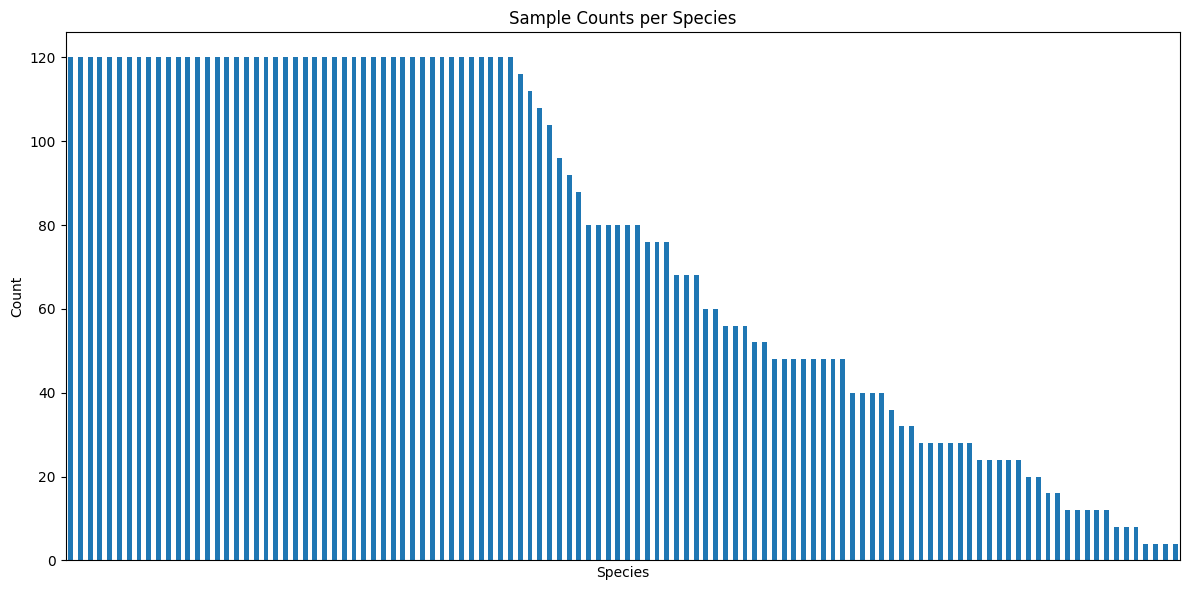

In [6]:
# Bar chart of sample counts per species
plt.figure(figsize=(12, 6))
df['species'].value_counts().plot(kind='bar')
plt.title("Sample Counts per Species")
plt.xlabel("Species")
plt.ylabel("Count")
plt.xticks([], [])
plt.tight_layout()
plt.show()

### Spectrogram Intensity Distribution
The boxplot below shows the mean spectrogram intensity for the top 10 species. There is significant overlap between species, suggesting that simpler supervised or unsupervised models may not be sufficient without deeper feature extraction.

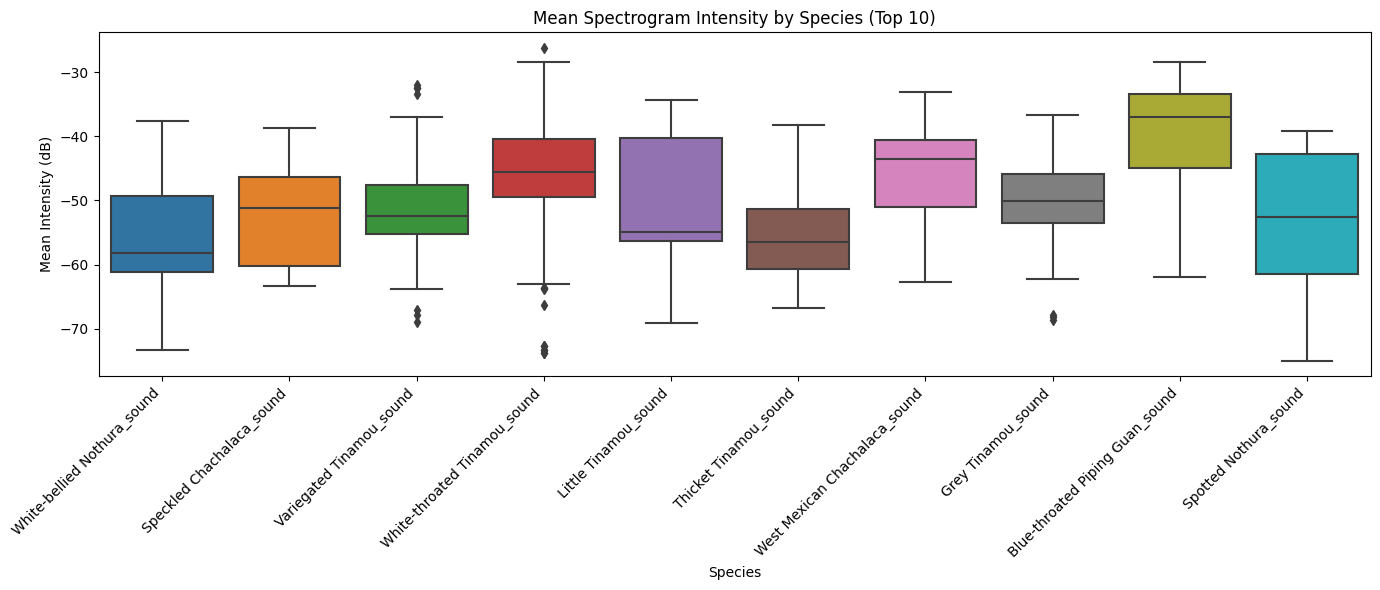

In [12]:
# Boxplot of mean spectrogram intensity
plt.figure(figsize=(14, 6))
top_species = df['species'].value_counts().nlargest(10).index
sns.boxplot(data=df[df['species'].isin(top_species)], x='species', y='mean_intensity')
plt.title("Mean Spectrogram Intensity by Species (Top 10)")
plt.xlabel("Species")
plt.ylabel("Mean Intensity (dB)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Average Spectrograms
This visualization shows the average spectrograms for a subset of species. It helps to understand the general structure and intensity patterns across time and frequency bins.

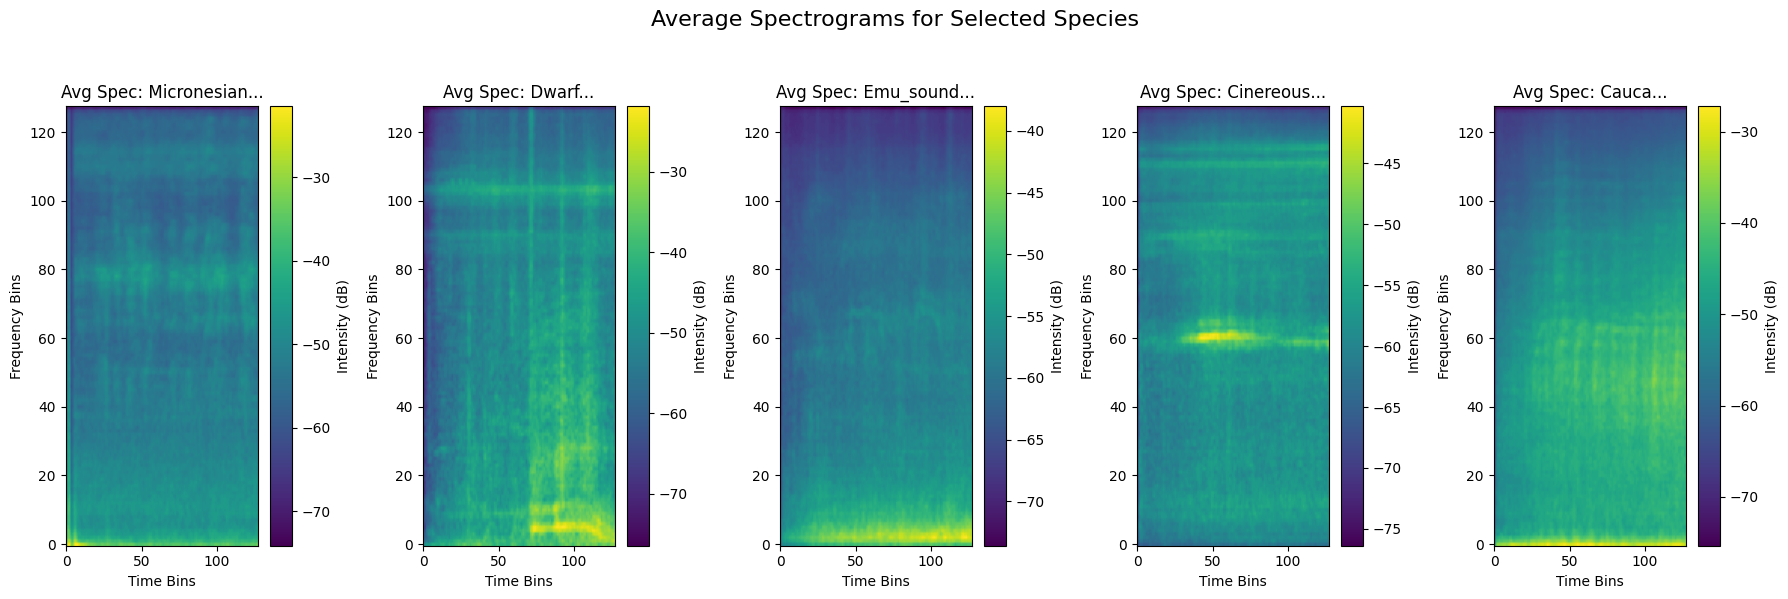

In [13]:
# Average spectrograms for selected species
plt.figure(figsize=(18, 6))
unique_species = df['species'].unique()
num_species_to_plot = min(5, len(unique_species))
for i, species in enumerate(unique_species[:num_species_to_plot]):
    species_spectrograms = np.stack(df[df['species'] == species]['spectrogram'].values).squeeze()
    avg_spec = np.mean(species_spectrograms, axis=0)
    plt.subplot(1, num_species_to_plot, i + 1)
    im = plt.imshow(avg_spec, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"Avg Spec: {species.split(' ')[0]}...")
    plt.xlabel("Time Bins")
    plt.ylabel("Frequency Bins")
    plt.colorbar(im, label="Intensity (dB)")
plt.suptitle("Average Spectrograms for Selected Species", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

### Distribution of Spectrogram Summary Features
Histograms and KDE plots show the distribution of calculated features such as mean, standard deviation, max, and min intensity.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

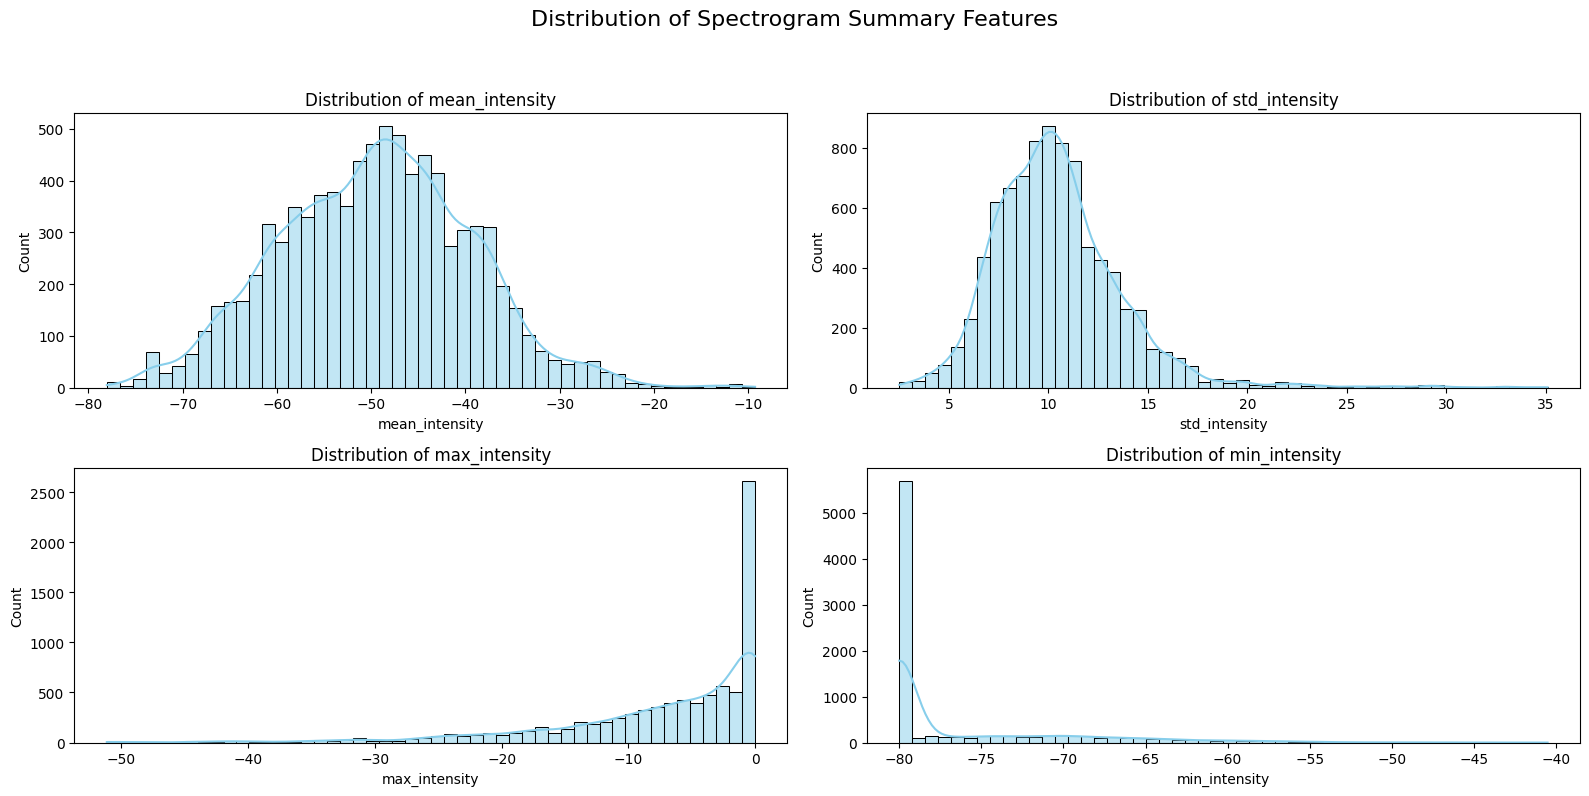

In [14]:
# Distribution of spectrogram summary features
summary_features_cols = ['mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity']
plt.figure(figsize=(16, 8))
for i, col in enumerate(summary_features_cols):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[col], kde=True, bins=50, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
plt.suptitle("Distribution of Spectrogram Summary Features", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

### t-SNE Projection
The t-SNE plot below visualizes clustering of species based on spectrogram summary features. Some separation is visible, but further modeling is needed to achieve reliable classification.

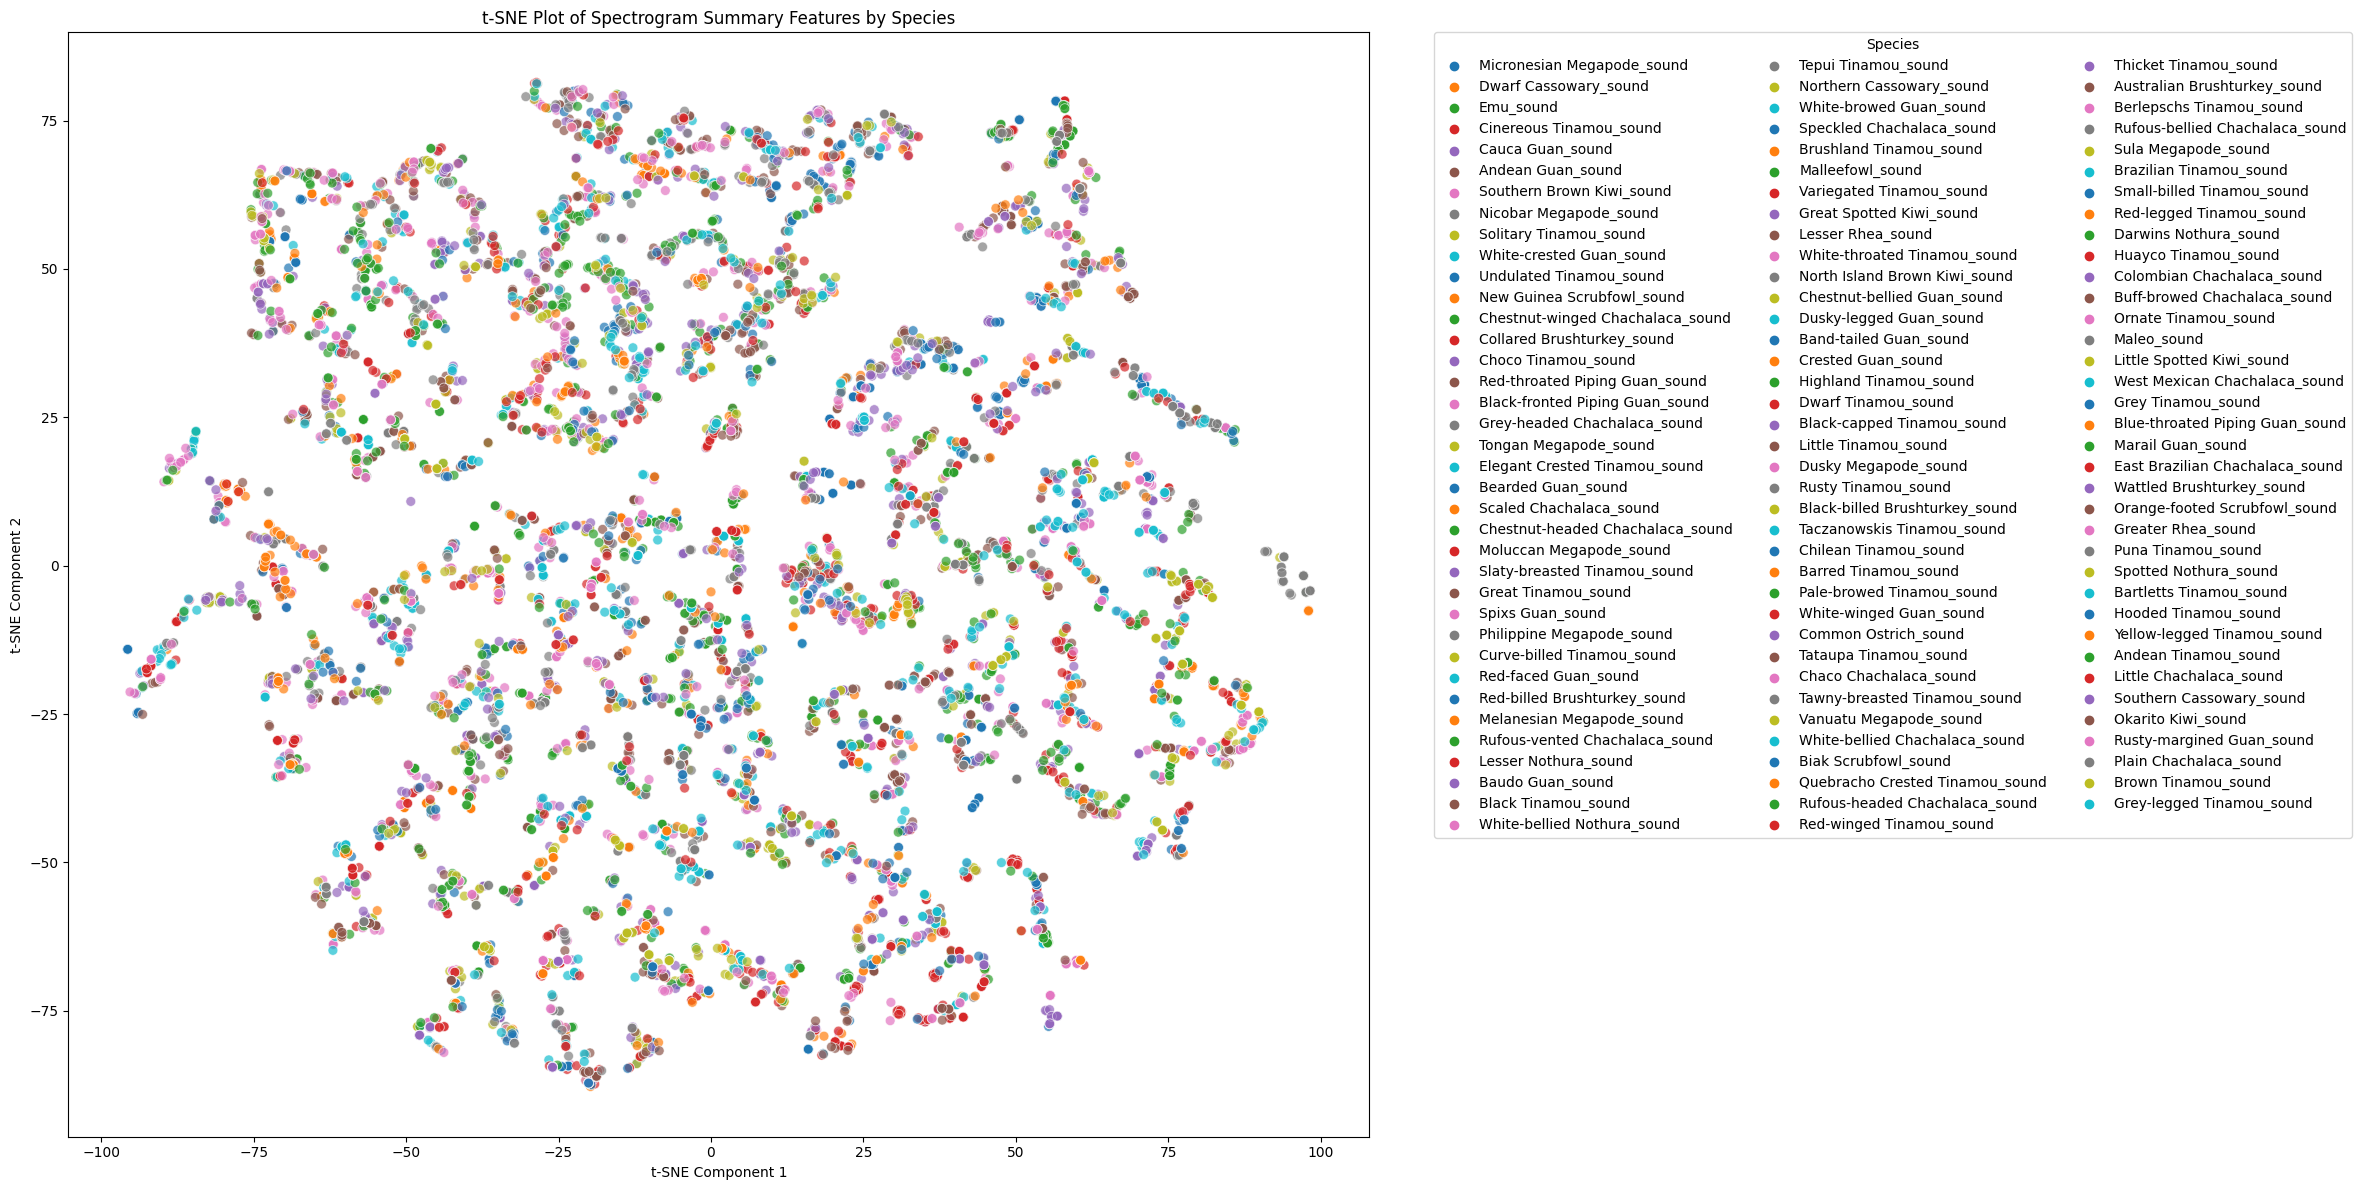

In [ ]:

# Assuming df is already defined and contains the necessary columns
X_tsne = df[['mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity']].values
y_species = df['species'].astype('category').cat.codes

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_tsne)-1), n_iter=1000)
X_tsne_reduced = tsne.fit_transform(X_tsne)

# Create the plot
plt.figure(figsize=(24,12))  # Wider figure
sns.scatterplot(x=X_tsne_reduced[:, 0], y=X_tsne_reduced[:, 1], hue=df['species'],
                palette='tab10', legend='full', alpha=0.7, s=50)

# Customize plot
plt.title("t-SNE Plot of Spectrogram Summary Features by Species")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Adjust legend to have 3 columns
plt.legend(title="Species", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=3)
plt.tight_layout()
plt.show()


##  CNN Model Training Strategy

To classify bird species based on their vocalizations, I trained a series of Convolutional Neural Network (CNN) models using the preprocessed Mel spectrograms as input. CNNs are well-suited for this task because spectrograms are essentially images, and CNNs excel at learning spatial hierarchies in image data.

### TPU Acceleration

To accelerate training and handle the large dataset more efficiently, I utilized **Google Cloud TPUs** where available. TPUs significantly reduce training time, especially when experimenting with multiple architectures and hyperparameters.

###  Model Architecture Strategy

I implemented and trained five different CNN architectures, each increasing in complexity and regularization:

- **Model 1**: A simple baseline CNN with one convolutional and pooling layer.
- **Model 2**: A deeper CNN with two convolutional layers and a larger dense layer.
- **Model 3**: Introduced dropout for regularization to reduce overfitting.
- **Model 4**: Added batch normalization to stabilize and accelerate training.
- **Model 5**: Included a residual connection to explore the benefits of skip connections.

Each model was trained using the same dataset split (train/validation/test) and evaluated using validation accuracy. The use of multiple architectures allowed for comparative analysis and ensemble modeling.

### Model Persistence

To support iterative development and future experimentation, **all trained models were saved** in `.h5` format. This enables:

- Easy reloading for evaluation or inference
- Ensemble modeling using pre-trained weights
- Avoiding redundant retraining

### Ensemble Model

An ensemble model was created by averaging the predictions of the first three CNNs. This approach often improves generalization by combining the strengths of multiple models and reducing variance.

### Training  Log Summary

All training results, including model names, architectures, validation accuracy, and training history, were logged and saved to a CSV file (`model_training_log.csv`). This structured logging supports reproducibility and future analysis.



In [ ]:
# Enable TPU strategy if available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU")
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default strategy for CPU/GPU
    print("Running on CPU/GPU")

In [4]:
# Load metadata CSV
csv_path = "/kaggle/input/bird-processed-sounds/birdsong_metadata_full.csv"
spec_dir = "/kaggle/input/bird-processed-sounds/proccessed_spectrograms/kaggle/temp/temp_bird_spectrograms_npy"

df = pd.read_csv(csv_path)

# Filter out species with fewer than 3 samples
species_counts = df['species'].value_counts()
valid_species = species_counts[species_counts >= 8].index
df = df[df['species'].isin(valid_species)].reset_index(drop=True)

# Load spectrograms and pad/truncate to (128, 128)
def load_and_fix_shape(path, target_shape=(128, 128)):
    try:
        spec = np.load(path)
        if spec.ndim == 1:
            spec = spec.reshape(128, -1)
        if spec.shape[0] != 128:
            return None
        if spec.shape[1] < 128:
            pad_width = 128 - spec.shape[1]
            spec = np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')
        elif spec.shape[1] > 128:
            spec = spec[:, :128]
        return spec
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

df['spectrogram'] = df['spectrogram_path_in_zip'].apply(
    lambda x: load_and_fix_shape(os.path.join(spec_dir, x))
)

df = df.dropna(subset=['spectrogram']).reset_index(drop=True)

# Encode labels
species_list = sorted(df['species'].unique())
species_to_idx = {name: i for i, name in enumerate(species_list)}
df['label'] = df['species'].map(species_to_idx)

# Prepare data arrays
X = np.stack(df['spectrogram'].values)
y = keras.utils.to_categorical(df['label'].values, num_classes=len(species_list))

# Stratified split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [ ]:
# Define model architectures
def build_model_1(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def build_model_2(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def build_model_3(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def build_model_4(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def build_model_5(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    residual = x
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.add([x, residual])
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

# Training function
def train_model(model_fn, model_name, X_train, y_train, X_val, y_val, input_shape, num_classes):
    with strategy.scope():
        model = model_fn(input_shape, num_classes)
        model.compile(optimizer=keras.optimizers.SGD(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=20, batch_size=64, verbose=0)
    model_path = f"{model_name}.h5"
    model.save(model_path)
    final_acc = history.history['val_accuracy'][-1]
    return model_path, history.history, final_acc

# Train base models
model_fns = [build_model_1, build_model_2, build_model_3, build_model_4, build_model_5]
model_names = [f"model_{i+1}" for i in range(5)]
results = []

for fn, name in tqdm(zip(model_fns, model_names), total=len(model_fns), desc="Training base models"):
    path, hist, acc = train_model(fn, name, X_train, y_train, X_val, y_val, X.shape[1:], y.shape[1])
    results.append({
        'model_name': name,
        'model_path': path,
        'hyperparameters': str(fn.__name__),
        'history': hist,
        'val_accuracy': acc
    })

# Ensemble model: average predictions from model_1, model_2, model_3
ensemble_models = [keras.models.load_model(f"model_{i+1}.h5") for i in range(3)]
ensemble_preds = np.mean([m.predict(X_val, batch_size=64) for m in ensemble_models], axis=0)
ensemble_acc = accuracy_score(np.argmax(y_val, axis=1), np.argmax(ensemble_preds, axis=1))

# Save ensemble model metadata
results.append({
    'model_name': 'ensemble_model',
    'model_path': 'ensemble_model (avg of model_1-3)',
    'hyperparameters': 'average of model_1, model_2, model_3',
    'history': 'N/A',
    'val_accuracy': ensemble_acc
})

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("model_training_log.csv", index=False)

### CNN Models result and evaluations

In [10]:
cnn_log = pd.read_csv("/kaggle/input/cnn-first-itteration/tensorflow2/default/1/model_training_log.csv")
cnn_log.head()

model_name  model_path hyperparameters  \
0    model_1  model_1.h5   build_model_1   
1    model_2  model_2.h5   build_model_2   
2    model_3  model_3.h5   build_model_3   
3    model_4  model_4.h5   build_model_4   
4    model_5  model_5.h5   build_model_5   

                                             history  val_accuracy  
0  {'accuracy': [0.02301705628633499, 0.039907269...      0.013910  
1  {'accuracy': [0.013909587636590004, 0.01390958...      0.013910  
2  {'accuracy': [0.01357840746641159, 0.013909587...      0.013910  
3  {'accuracy': [0.2667660117149353, 0.6320582628...      0.748068  
4  {'accuracy': [0.013743997551500797, 0.01390958...      0.013910

### Discussion and Results

The following evaluation pertains exclusively to **Model 4**, which demonstrated the strongest performance during preliminary experimentation. To maintain clarity and avoid clutter, evaluations of other models are omitted from this section. The classification report below summarizes precision, recall, and F1-score for each class. Notably, the overall accuracy achieved was **77%**, with a **weighted average F1-score of 0.78** across all 110 classes. Tt is evident that accuracy varies significantly across different classes. While some classes achieve near-perfect precision and recall, others suffer from poor performance, with several classes receiving a score of zero due to no predicted samples. This fluctuation strongly suggests that **class imbalance** I have detected earlier is a contributing factor. Classes with fewer samples tend to be underrepresented in predictions, leading to lower precision and recall. Addressing this imbalance—through techniques such as  **class weighting**, or **resampling**—may improve future model performance.

### Additional Visualizations

To further illustrate model behavior and performance, the following plots are provided:

- **Confusion Matrix**: Offers a detailed view of prediction errors across all classes.
- **Generic ROC Curve**: Aggregated ROC curve for overall model performance.
- **ROC Curves for Top 10 Classes**: Individual ROC curves for the ten most frequent or best-performing classes.


I0000 00:00:1753658268.788385      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:18275207216052498391
E0000 00:00:1753658268.796766      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node sequential_3_1/batch_normalization_1/Cast/ReadVariableOp.


188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

I0000 00:00:1753658275.324999      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:18311919627855047050


189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


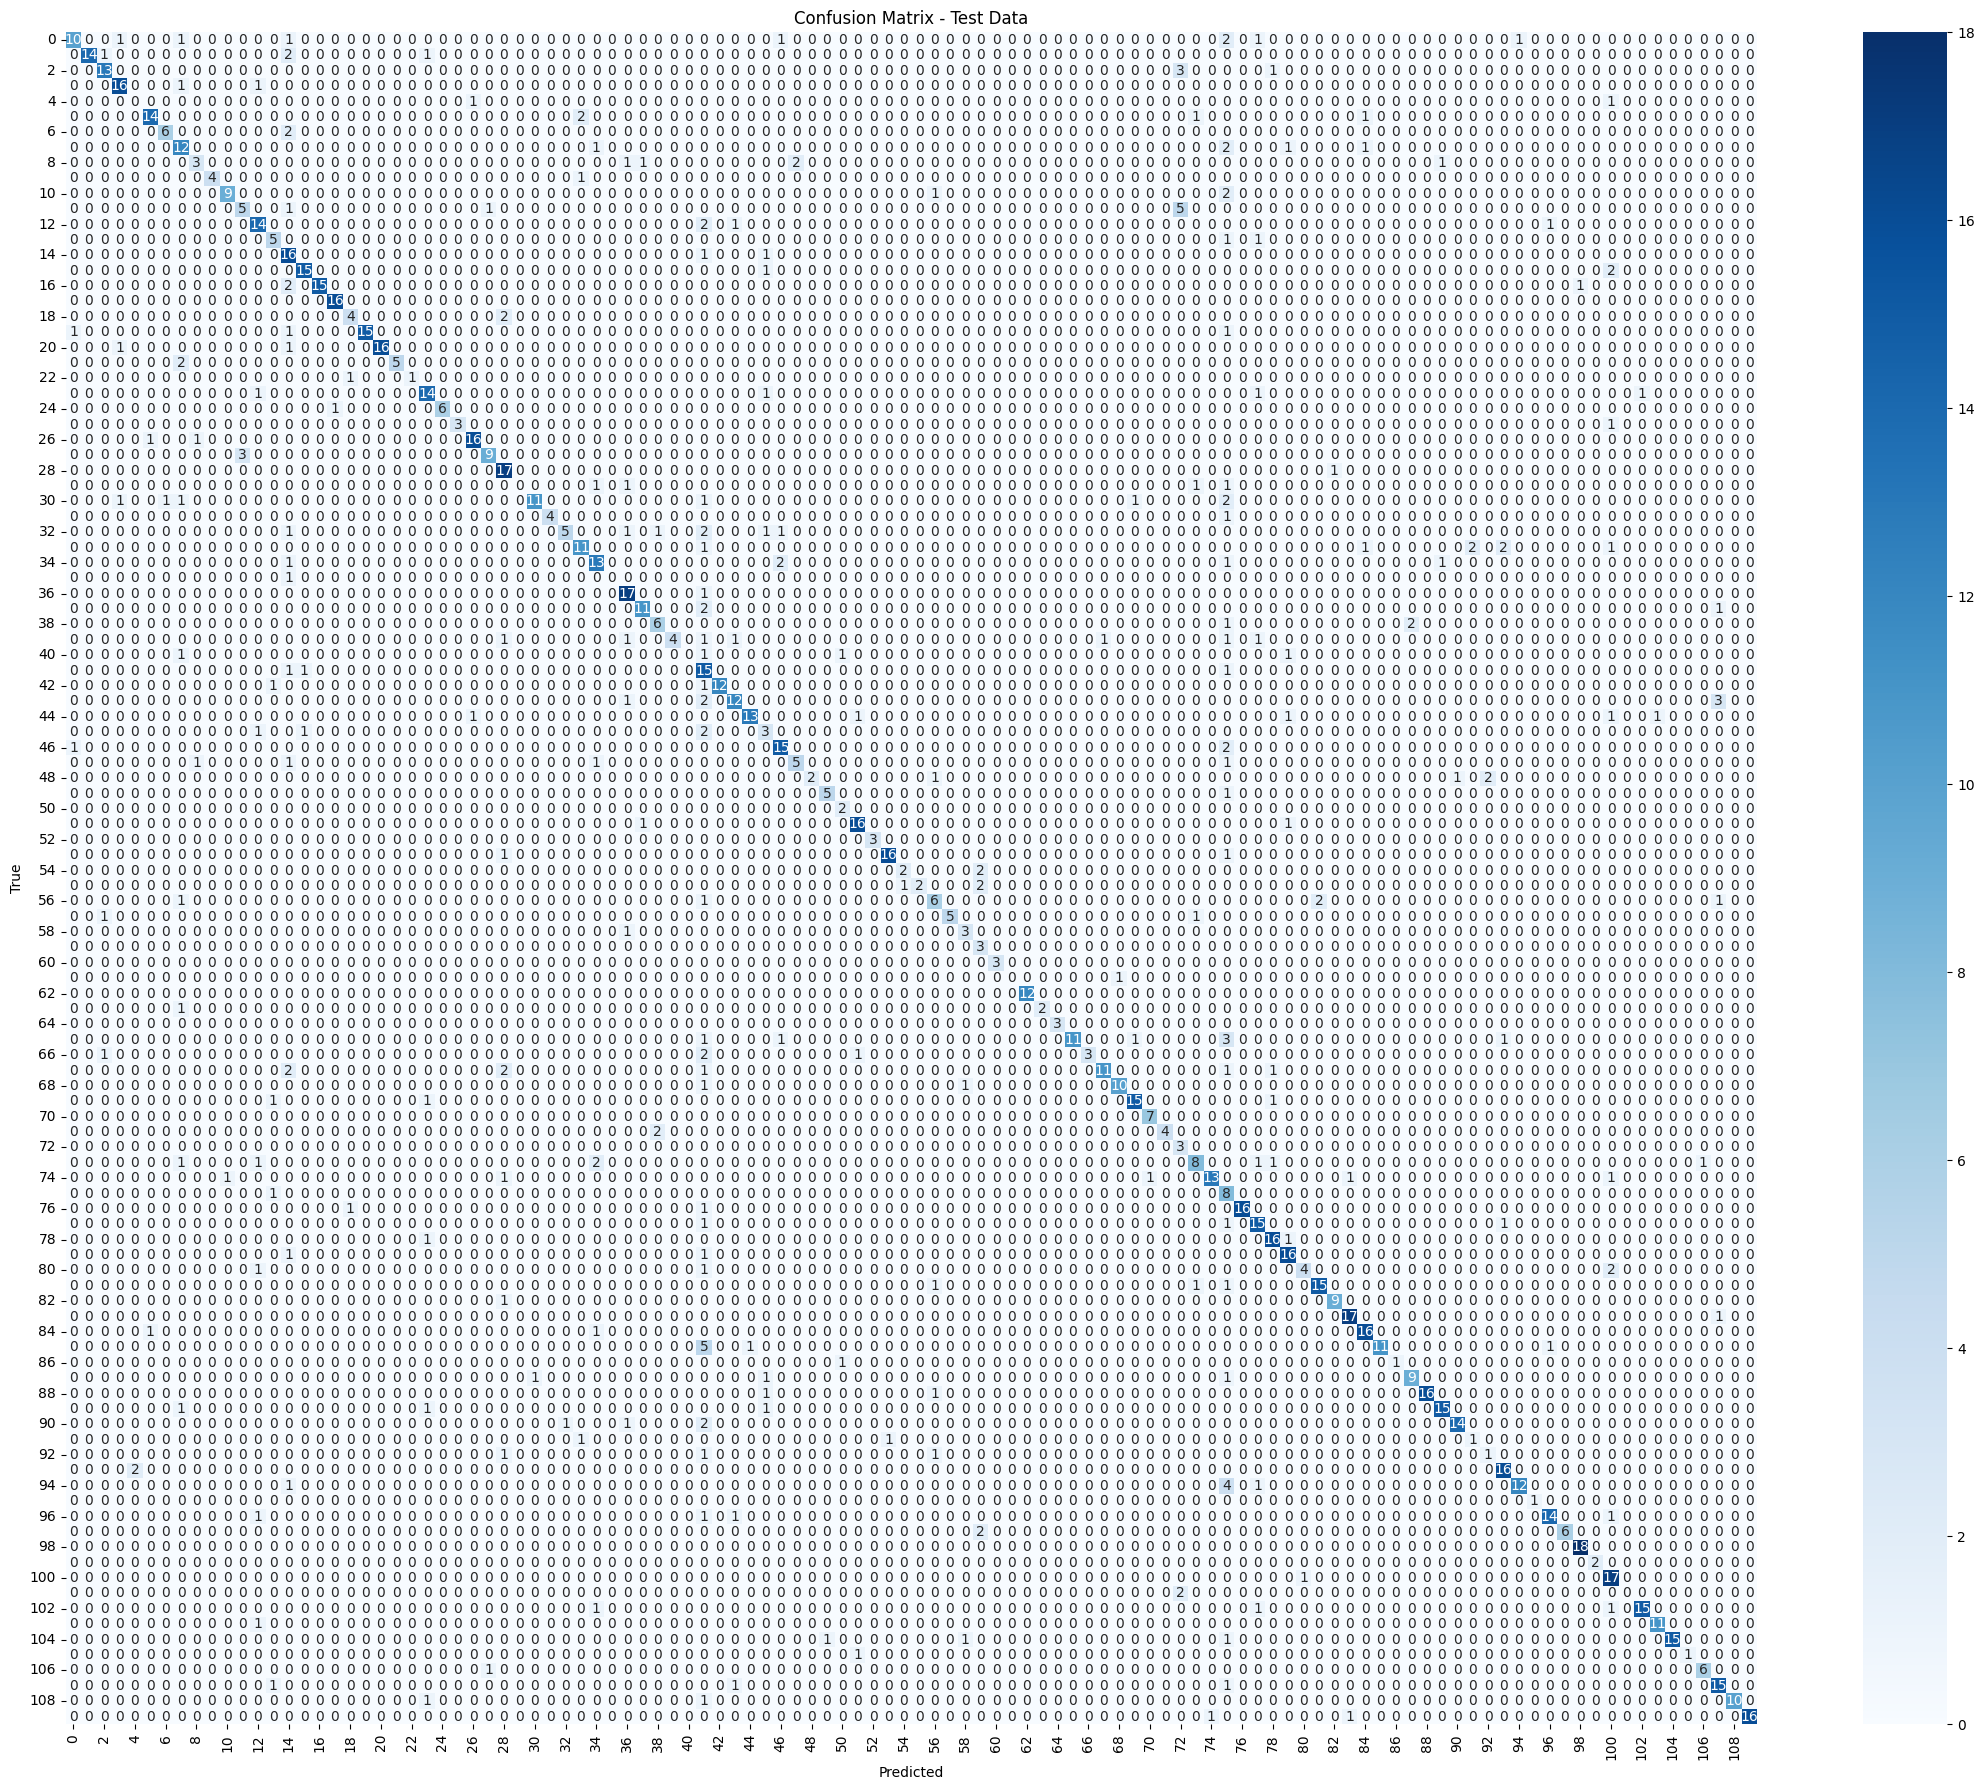

Classification Report (Test Data):


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

           0       0.83      0.56      0.67        18
           1       1.00      0.78      0.88        18
           2       0.81      0.76      0.79        17
           3       0.84      0.89      0.86        18
           4       0.00      0.00      0.00         2
           5       0.88      0.78      0.82        18
           6       0.86      0.75      0.80         8
           7       0.55      0.71      0.62        17
           8       0.60      0.38      0.46         8
           9       1.00      0.80      0.89         5
          10       0.90      0.75      0.82        12
          11       0.62      0.42      0.50        12
          12       0.67      0.78      0.72        18
          13       0.56      0.71      0.62         7
          14       0.46      0.89      0.60        18
          15       0.88      0.83      0.86        18
          16       1.00      0.83      0.91        18
          17       0.94    

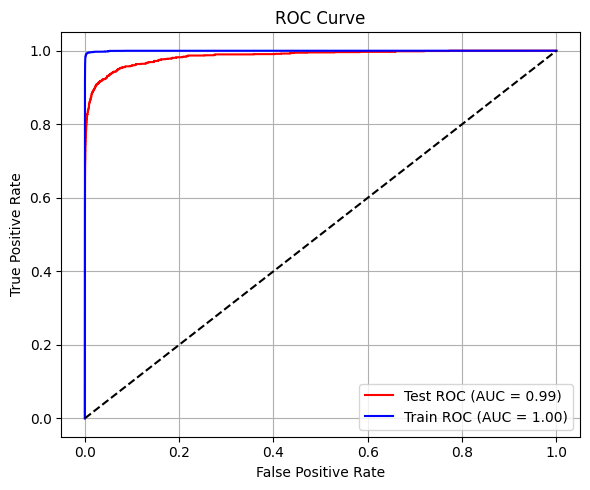

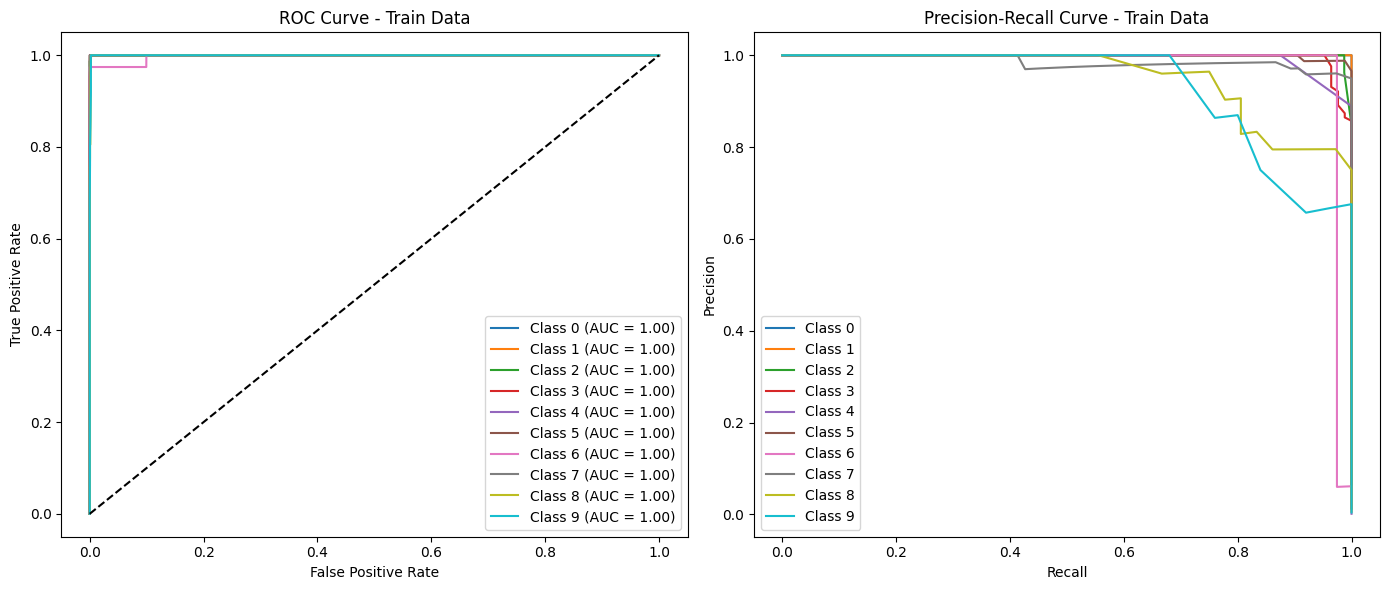

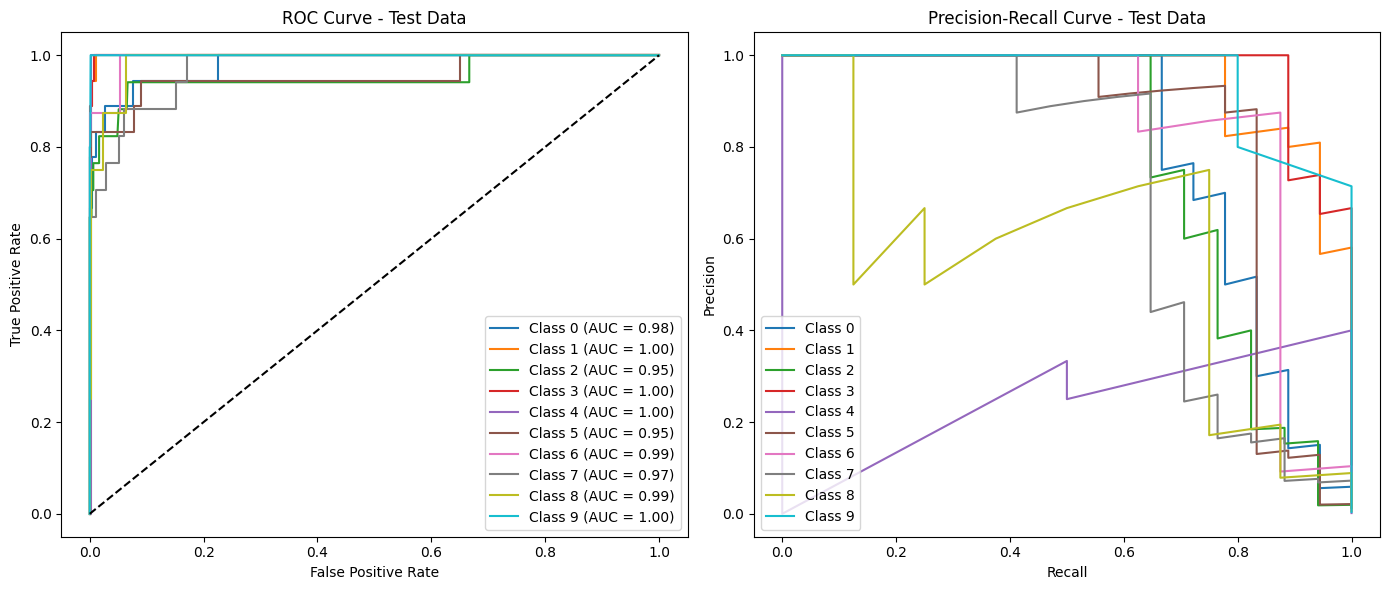

In [ ]:

def evaluate_model(model_path):
    # Load model
    with strategy.scope():
         model = keras.models.load_model(model_path)
    
     
    # Predict on train and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Convert predictions and true labels to class indices
    y_train_true = np.argmax(y_train, axis=1)
    y_test_true = np.argmax(y_test, axis=1)
    y_train_pred_classes = np.argmax(y_train_pred, axis=1)
    y_test_pred_classes = np.argmax(y_test_pred, axis=1)
    
    # Confusion matrix plot
    def plot_confusion_matrix(y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(22, 18))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {title}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()
    
    plot_confusion_matrix(y_test_true, y_test_pred_classes, "Test Data")
    
    # Classification report
    print("Classification Report (Test Data):")
    print(classification_report(y_test_true, y_test_pred_classes))
    
    #ROC curves 

    # ROC Curve(generic)
    y_test_bin = y_test
    y_train_bin = y_train
    fpr_test, tpr_test, _ = roc_curve(y_test_bin.ravel(), y_test_pred.ravel())
    fpr_train, tpr_train, _ = roc_curve(y_train_bin.ravel(), y_train_pred.ravel())
    auc_test = auc(fpr_test, tpr_test)
    auc_train = auc(fpr_train, tpr_train)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.2f})', color='red')
    plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



    
    def plot_roc_pr_curves(y_true, y_pred, dataset_label):
        # Limit to first 10 classes
        n_classes = min(10, y_pred.shape[1])
        y_true_bin = label_binarize(y_true, classes=np.arange(y_pred.shape[1]))[:, :n_classes]
        y_pred = y_pred[:, :n_classes]
    
        # ROC Curve
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'ROC Curve - {dataset_label}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
    
        # Precision-Recall Curve
        plt.subplot(1, 2, 2)
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
            plt.plot(recall, precision, label=f'Class {i}')
        plt.title(f'Precision-Recall Curve - {dataset_label}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
    
        plt.tight_layout()
        plt.show()

    plot_roc_pr_curves(y_train_true, y_train_pred, "Train Data")
    plot_roc_pr_curves(y_test_true, y_test_pred, "Test Data")

evaluate_model('/kaggle/input/cnn-first-itteration/tensorflow2/default/1/model_4.h5')

##  RNN Model Training Strategy

While CNNs are excellent at capturing spatial patterns in spectrograms, **Recurrent Neural Networks (RNNs)** offer a distinct advantage: they can model **temporal dependencies**. This is particularly valuable for bird song classification, where the **sequence and rhythm** of sounds often carry species-specific information.

### Temporal Modeling with RNNs

In this phase, I reshaped each Mel spectrogram into a sequence of 128 time steps, each with 128 frequency features. This allowed the RNNs to process the spectrograms as time-series data, capturing how frequency content evolves over time.

### Model Variants

I trained five RNN-based architectures, each exploring different temporal modeling strategies:

- **Model 1**: Basic GRU layer
- **Model 2**: Basic LSTM layer
- **Model 3**: Stacked LSTMs for deeper temporal learning
- **Model 4**: Bidirectional LSTM with dropout for regularization
- **Model 5**: Bidirectional LSTM with an attention mechanism to focus on the most informative time steps

### TPU Acceleration & Model Saving

As with the CNNs, training was accelerated using **TPUs** to reduce runtime. Each trained model was saved in `.h5` format, enabling:

- Easy reuse for inference or ensemble modeling
- Consistent evaluation across experiments
- Efficient iteration without retraining

### Ensemble Model

To further improve performance, I created an **ensemble model** by averaging the predictions of the first three RNNs. This ensemble approach helps reduce variance and often leads to more stable predictions.

### Logging and Evaluation

All training results, including validation accuracy and model metadata, were logged to `rnn_model_training_log.csv`. This structured logging supports reproducibility and future analysis.



In [ ]:
# Load metadata CSV
csv_path = "/kaggle/input/bird-processed-sounds/birdsong_metadata_full.csv"
spec_dir = "/kaggle/input/bird-processed-sounds/proccessed_spectrograms/kaggle/temp/temp_bird_spectrograms_npy"

df = pd.read_csv(csv_path)

# Filter out species with fewer than 3 samples
species_counts = df['species'].value_counts()
valid_species = species_counts[species_counts >= 8].index
df = df[df['species'].isin(valid_species)].reset_index(drop=True)

# Load spectrograms and pad/truncate to (128, 128)
def load_and_fix_shape(path, target_shape=(128, 128)):
    try:
        spec = np.load(path)
        if spec.ndim == 1:
            spec = spec.reshape(128, -1)
        if spec.shape[0] != 128:
            return None
        if spec.shape[1] < 128:
            pad_width = 128 - spec.shape[1]
            spec = np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')
        elif spec.shape[1] > 128:
            spec = spec[:, :128]
        return spec
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

df['spectrogram'] = df['spectrogram_path_in_zip'].apply(
    lambda x: load_and_fix_shape(os.path.join(spec_dir, x))
)

df = df.dropna(subset=['spectrogram']).reset_index(drop=True)

# Encode labels
species_list = sorted(df['species'].unique())
species_to_idx = {name: i for i, name in enumerate(species_list)}
df['label'] = df['species'].map(species_to_idx)

# Prepare data arrays
X = np.stack(df['spectrogram'].values)
y = keras.utils.to_categorical(df['label'].values, num_classes=len(species_list))

# Stratified split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Reshape for RNNs: (batch, time_steps, features)
X_train_rnn = X_train.reshape((-1, 128, 128))
X_val_rnn = X_val.reshape((-1, 128, 128))
X_test_rnn = X_test.reshape((-1, 128, 128))

# Attention layer
def attention_layer(inputs):
    score = layers.Dense(1, activation='tanh')(inputs)
    weights = layers.Softmax(axis=1)(score)
    context = layers.Multiply()([inputs, weights])
    context = tf.reduce_sum(context, axis=1)
    return context

# RNN model definitions
def build_rnn_model_1(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(64),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def build_rnn_model_2(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(64),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def build_rnn_model_3(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def build_rnn_model_4(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Dropout(0.3),
        layers.LSTM(64),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def build_rnn_model_5(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inputs)
    x = attention_layer(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

# Training function
def train_model(model_fn, model_name, X_train, y_train, X_val, y_val, input_shape, num_classes):
    with strategy.scope():
        model = model_fn(input_shape, num_classes)
        model.compile(optimizer=keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'],
                      steps_per_execution=32)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=20, batch_size=16 * strategy.num_replicas_in_sync, verbose=0)
    save_opts = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    model.save(f"{model_name}.h5")
    final_acc = history.history['val_accuracy'][-1]
    return f"{model_name}.h5", history.history, final_acc

# Train RNN models
model_fns = [build_rnn_model_1, build_rnn_model_2, build_rnn_model_3, build_rnn_model_4, build_rnn_model_5]
model_names = [f"rnn_model_{i+1}" for i in range(5)]
results = []

for fn, name in tqdm(zip(model_fns, model_names), total=len(model_fns), desc="Training RNN models"):
    path, hist, acc = train_model(fn, name, X_train_rnn, y_train, X_val_rnn, y_val, X_train_rnn.shape[1:], y.shape[1])
    results.append({
        'model_name': name,
        'model_path': path,
        'hyperparameters': str(fn.__name__),
        'history': hist,
        'val_accuracy': acc
    })

# Ensemble model (average of first 3 RNNs)
ensemble_models = [keras.models.load_model(f"rnn_model_{i+1}.h5", compile=False) for i in range(3)]
ensemble_preds = np.mean([m.predict(X_val_rnn, batch_size=64) for m in ensemble_models], axis=0)
ensemble_acc = accuracy_score(np.argmax(y_val, axis=1), np.argmax(ensemble_preds, axis=1))

results.append({
    'model_name': 'ensemble_model',
    'model_path': 'ensemble_model (avg of rnn_model_1-3)',
    'hyperparameters': 'average of rnn_model_1, rnn_model_2, rnn_model_3',
    'history': 'N/A',
    'val_accuracy': ensemble_acc
})

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("rnn_model_training_log.csv", index=False)



### RNN Models result and evaluations

In [11]:
rnn_log = pd.read_csv("/kaggle/input/rnn_models/tensorflow2/default/1/rnn_model_training_log.csv")
rnn_log.head()

model_name      model_path    hyperparameters  \
0  rnn_model_1  rnn_model_1.h5  build_rnn_model_1   
1  rnn_model_2  rnn_model_2.h5  build_rnn_model_2   
2  rnn_model_3  rnn_model_3.h5  build_rnn_model_3   
3  rnn_model_4  rnn_model_4.h5  build_rnn_model_4   

                                             history  val_accuracy  
0  {'accuracy': [0.006954793818295002, 0.02401059...      0.127512  
1  {'accuracy': [0.013743997551500797, 0.01440635...      0.056414  
2  {'accuracy': [0.014737538993358612, 0.02136115...      0.039413  
3  {'accuracy': [0.012750455178320408, 0.01506872...      0.035549

### Discussion and Results

The best model(i.e., model_1) achieved limited success, with an overall accuracy of **13%** and a macro-averaged F1-score of **0.07**. Most classes received zero scores across precision and recall, with only a few showing modest performance. This suggests the model struggled to generalize across the dataset. A key reason for this underperformance is that the dataset was originally processed with CNNs in mind, using spectrogram-like inputs that are spatially structured. RNNs, however, are better suited for sequential data such as raw audio or MFCCs. Feeding them 2D spectrograms limits their ability to capture temporal patterns effectively. Future improvements could include preprocessing MP3 files into **MFCCs**, **chroma features**, or **raw waveform segments**, which align better with RNN architectures. Unfortunately, due to time constraints, these enhancements could not be implemented within the current project timeline.


I0000 00:00:1753659252.651144      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:6643104622558057404
E0000 00:00:1753659252.665844      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node sequential_1_1/dense_1_1/BiasAdd/ReadVariableOp.
I0000 00:00:1753659252.707275     962 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16397200375256707859), session_name()
I0000 00:00:1753659252.841089     962 tpu_compile_op_common.cc:245] Compilation of 16397200375256707859 with session name  took 133.755943ms and succeeded
I0000 00:00:1753659252.841797     962 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16397200375256707859), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_6643104622558057404", property.function_library_fingerprint = 16590106581388785702, property.mlir_module_finge

187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

I0000 00:00:1753659259.238788      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:13639744835423569421
I0000 00:00:1753659259.333680     958 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16932398457137718984), session_name()
I0000 00:00:1753659259.539211     958 tpu_compile_op_common.cc:245] Compilation of 16932398457137718984 with session name  took 205.491503ms and succeeded
I0000 00:00:1753659259.540347     958 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16932398457137718984), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13639744835423569421", property.function_library_fingerprint = 4532617033115630028, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, to

189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

I0000 00:00:1753659262.202563     903 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(3331802470926469983), session_name()
I0000 00:00:1753659262.400015     903 tpu_compile_op_common.cc:245] Compilation of 3331802470926469983 with session name  took 197.411776ms and succeeded
I0000 00:00:1753659262.401049     903 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(3331802470926469983), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13639744835423569421", property.function_library_fingerprint = 4532617033115630028, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,128,128,;", property.guaranteed_constants_size = 0, embeddi

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


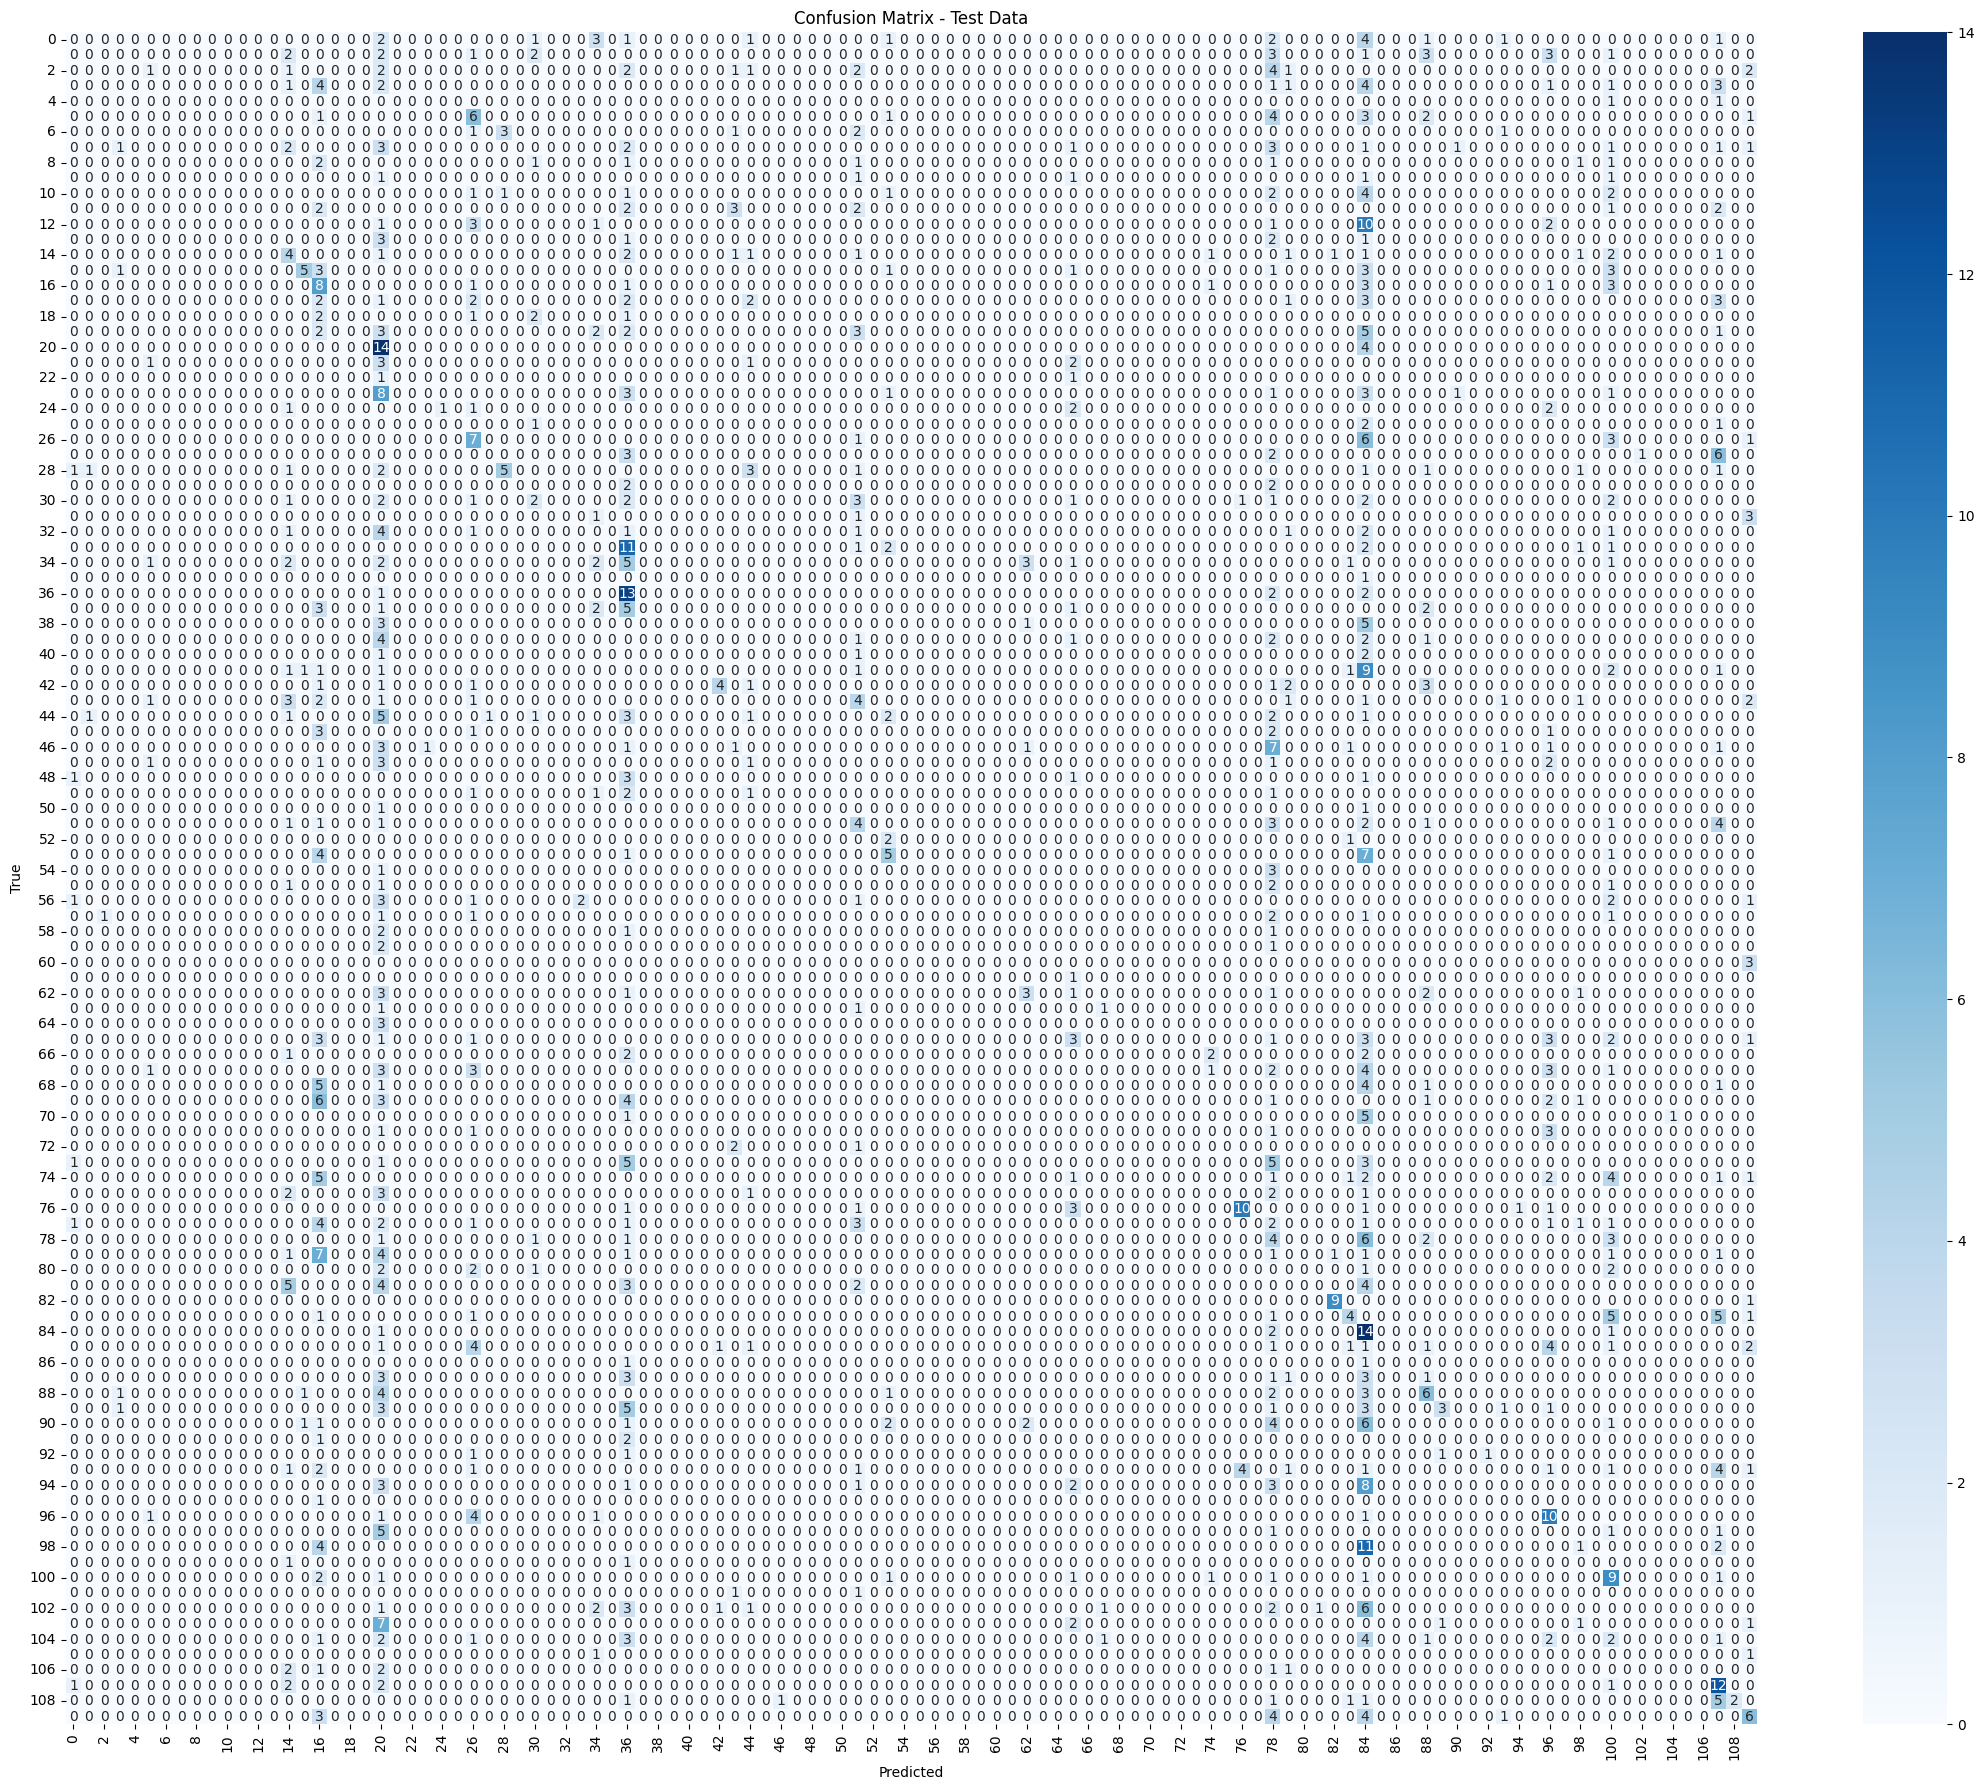

Classification Report (Test Data):


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.00      0.00      0.00        18
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00        12
          11       0.00      0.00      0.00        12
          12       0.00      0.00      0.00        18
          13       0.00      0.00      0.00         7
          14       0.11      0.22      0.14        18
          15       0.62      0.28      0.38        18
          16       0.09      0.44      0.15        18
          17       0.00    

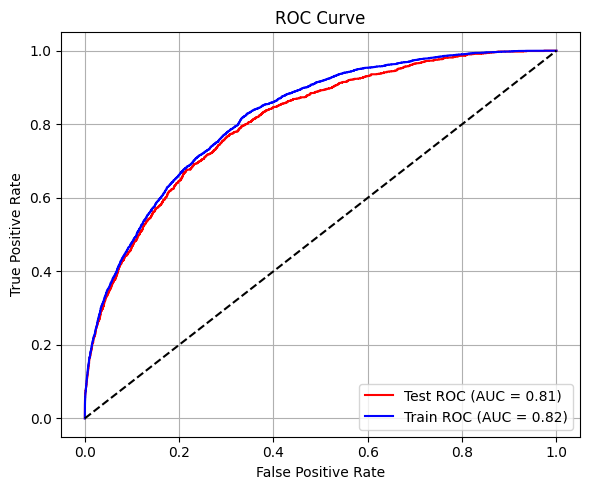

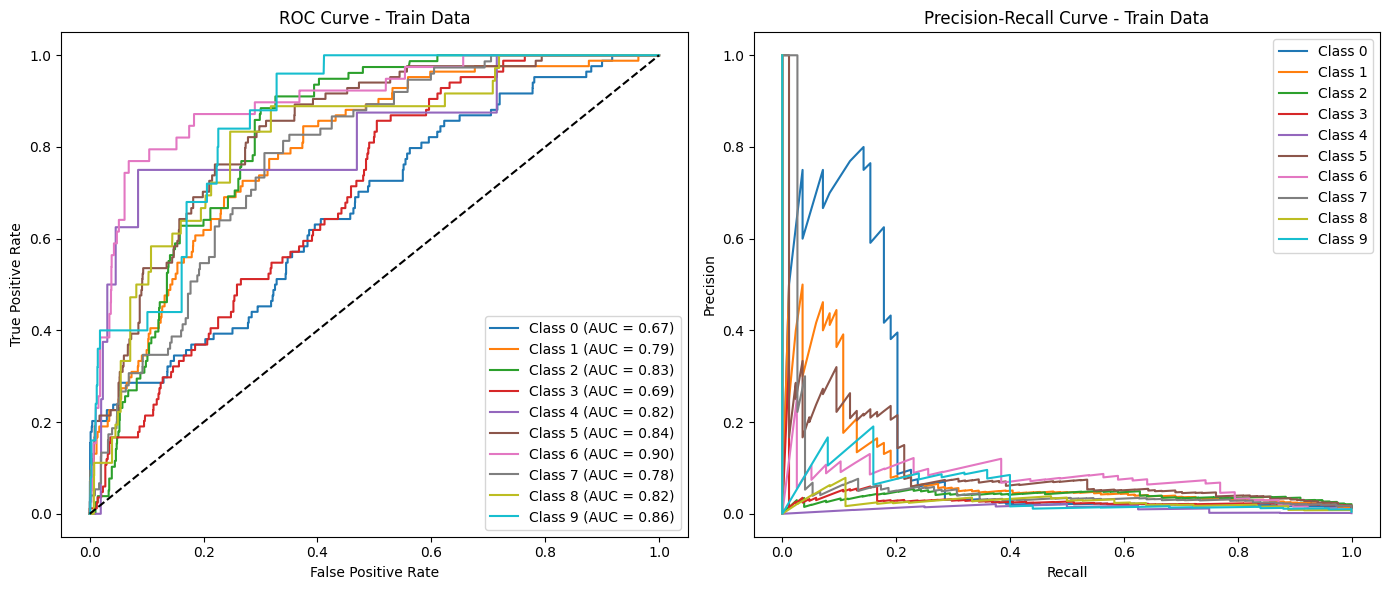

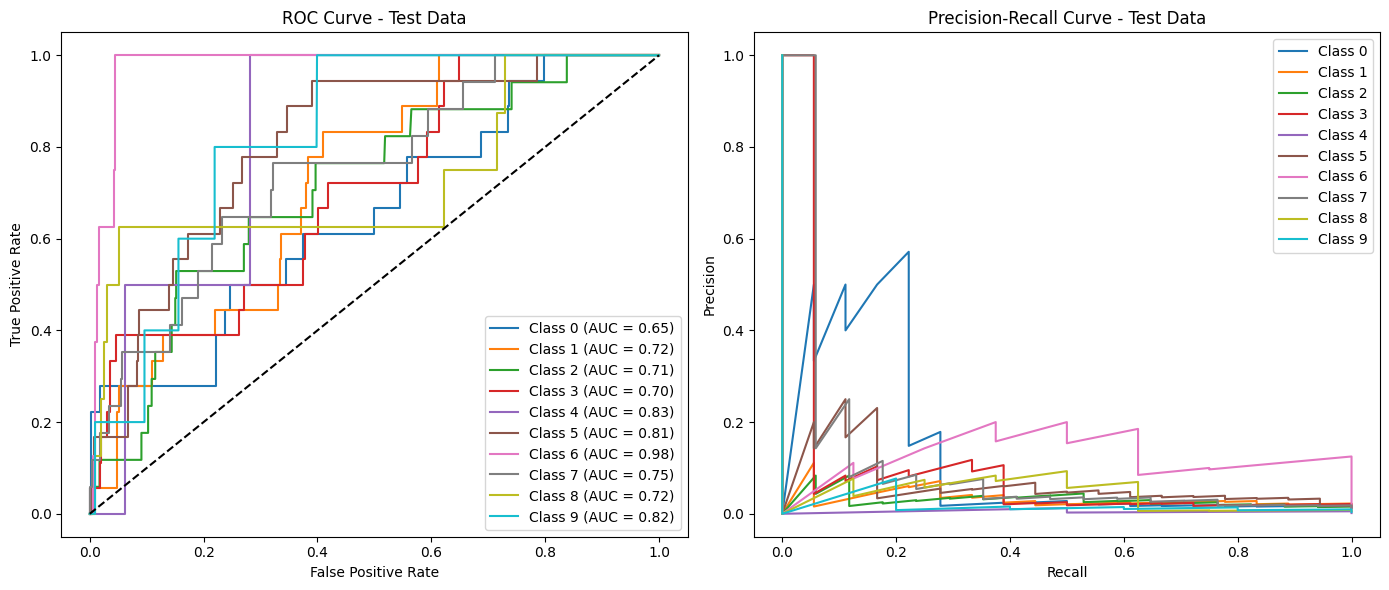

In [10]:
evaluate_model('/kaggle/input/rnn_models/tensorflow2/default/1/rnn_model_1.h5')

## Hybrid CNN-RNN Model Strategy

To leverage the strengths of both CNNs and RNNs, I developed a series of **hybrid models** that combine spatial and temporal feature extraction. These models aim to capture both the **local frequency patterns** (via CNNs) and the **temporal dynamics** (via RNNs) of bird vocalizations. While  **CNNs** are effective at identifying local patterns in spectrograms, such as frequency peaks and harmonics, **RNNs** (especially GRUs and LSTMs) are designed to model sequential dependencies, which are crucial for understanding the rhythm and progression of bird songs. By combining both, hybrid models can learn **richer representations** that neither architecture could capture alone.

### Model Variants

I trained three hybrid architectures with increasing complexity:

- **Hybrid Model 1**: A simple CNN followed by a GRU layer.
- **Hybrid Model 2**: A deeper CNN stack with batch normalization and a bidirectional LSTM.
- **Hybrid Model 3**: A deeper CNN + BiLSTM model enhanced with an **attention mechanism** to focus on the most informative time steps.

Each model reshapes the CNN output into a sequence before feeding it into the RNN layers, allowing the network to learn both spatial and temporal features in a unified pipeline.

### TPU Acceleration & Model Saving

Training was accelerated using **TPUs**, and all models were saved in `.h5` format for future reuse, evaluation, and ensemble modeling.

### Logging and Evaluation

Training results, including validation accuracy and model metadata, were saved to `hybrid_model_training_log.csv`. This ensures reproducibility and supports future comparative analysis.



In [ ]:
# Hybrid model definitions
def build_hybrid_model_1(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape + (1,))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Reshape((63, -1))(x)
    x = layers.GRU(64)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

def build_hybrid_model_2(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape + (1,))
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Reshape((30, -1))(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

def build_hybrid_model_3(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape + (1,))
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Reshape((30, -1))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    attention = layers.Dense(1, activation='tanh')(x)
    attention = layers.Softmax(axis=1)(attention)
    x = layers.Multiply()([x, attention])
    x = tf.reduce_sum(x, axis=1)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# Training function
def train_model(model_fn, model_name, X_train, y_train, X_val, y_val, input_shape, num_classes):
    with strategy.scope():
        model = model_fn(input_shape, num_classes)
        model.compile(optimizer=keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'],
                      steps_per_execution=32)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=20, batch_size=16 * strategy.num_replicas_in_sync, verbose=0)
    model.save(f"{model_name}.h5")
    final_acc = history.history['val_accuracy'][-1]
    return f"{model_name}.h5", history.history, final_acc

# Train hybrid models
model_fns = [build_hybrid_model_1, build_hybrid_model_2, build_hybrid_model_3]
model_names = [f"hybrid_model_{i+1}" for i in range(3)]
results = []

for fn, name in tqdm(zip(model_fns, model_names), total=len(model_fns), desc="Training hybrid models"):
    path, hist, acc = train_model(fn, name, X_train, y_train, X_val, y_val, X_train.shape[1:], y.shape[1])
    results.append({
        'model_name': name,
        'model_path': path,
        'hyperparameters': str(fn.__name__),
        'history': hist,
        'val_accuracy': acc
    })

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("hybrid_model_training_log.csv", index=False)

### Hibryd Models result and evaluations

In [12]:
rnn_log = pd.read_csv("/kaggle/input/cnn-rnn-hybrid/tensorflow2/default/1/hybrid_model_training_log.csv")
rnn_log.head()

model_name         model_path       hyperparameters  \
0  hybrid_model_1  hybrid_model_1.h5  build_hybrid_model_1   
1  hybrid_model_2  hybrid_model_2.h5  build_hybrid_model_2   

                                             history  val_accuracy  
0  {'accuracy': [0.011094552464783192, 0.01175691...      0.324575  
1  {'accuracy': [0.04785560443997383, 0.142076507...      0.769706

### Results and Discussion

Among all tested architectures, **Hybrid Model #2** delivered the strongest performance, achieving an overall accuracy of **79%** and a macro-averaged F1-score of **0.72**. This model combines convolutional layers for spatial feature extraction with recurrent layers for temporal pattern recognition, effectively leveraging the strengths of both CNNs and RNNs. Its architecture allows it to first capture local patterns in spectrograms and then model their sequential dependencies, which is particularly well-suited for bird song classification.

Compared to the pure CNN model, which performed well on spatially structured spectrograms but lacked temporal awareness, the hybrid model demonstrates a clear advantage in handling the sequential nature of audio data. It also significantly outperforms the standalone RNN model, which struggled due to being fed spectrograms rather than raw or sequentially structured audio features.

Further improvements could be achieved by refining the preprocessing pipeline. For instance, a more modular approach could involve using a CNN to extract high-level features from spectrograms, followed by a specialized RNN (e.g., bidirectional GRU or LSTM with attention) to analyze temporal dynamics. Alternatively, raw audio could first be processed with an RNN to capture temporal cues, and the resulting embeddings could be passed to a CNN for spatial pattern recognition. While promising, these enhancements were beyond the scope of the current project timeline.


I0000 00:00:1753660154.803844      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:11343424276675886576
E0000 00:00:1753660154.828762      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_6_1/batch_normalization_1/Cast/ReadVariableOp.
I0000 00:00:1753660154.890901     953 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(496132765589183844), session_name()
I0000 00:00:1753660157.050562     953 tpu_compile_op_common.cc:245] Compilation of 496132765589183844 with session name  took 2.15961489s and succeeded
I0000 00:00:1753660157.052353     953 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(496132765589183844), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11343424276675886576", property.function_library_fingerprint = 10513923083139310701, property.mlir_module_f

187/189 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

I0000 00:00:1753660163.768380      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:11138833746625342683
I0000 00:00:1753660163.907489     946 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(6761809731692980283), session_name()
I0000 00:00:1753660166.068113     946 tpu_compile_op_common.cc:245] Compilation of 6761809731692980283 with session name  took 2.160578144s and succeeded
I0000 00:00:1753660166.070416     946 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(6761809731692980283), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11138833746625342683", property.function_library_fingerprint = 10861452586748956207, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topo

189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

I0000 00:00:1753660168.703495     936 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(9096407663952846463), session_name()
I0000 00:00:1753660172.363048     936 tpu_compile_op_common.cc:245] Compilation of 9096407663952846463 with session name  took 3.659506255s and succeeded
I0000 00:00:1753660172.365894     936 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(9096407663952846463), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11138833746625342683", property.function_library_fingerprint = 10861452586748956207, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,128,128,;", property.guaranteed_constants_size = 0, embedd

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step


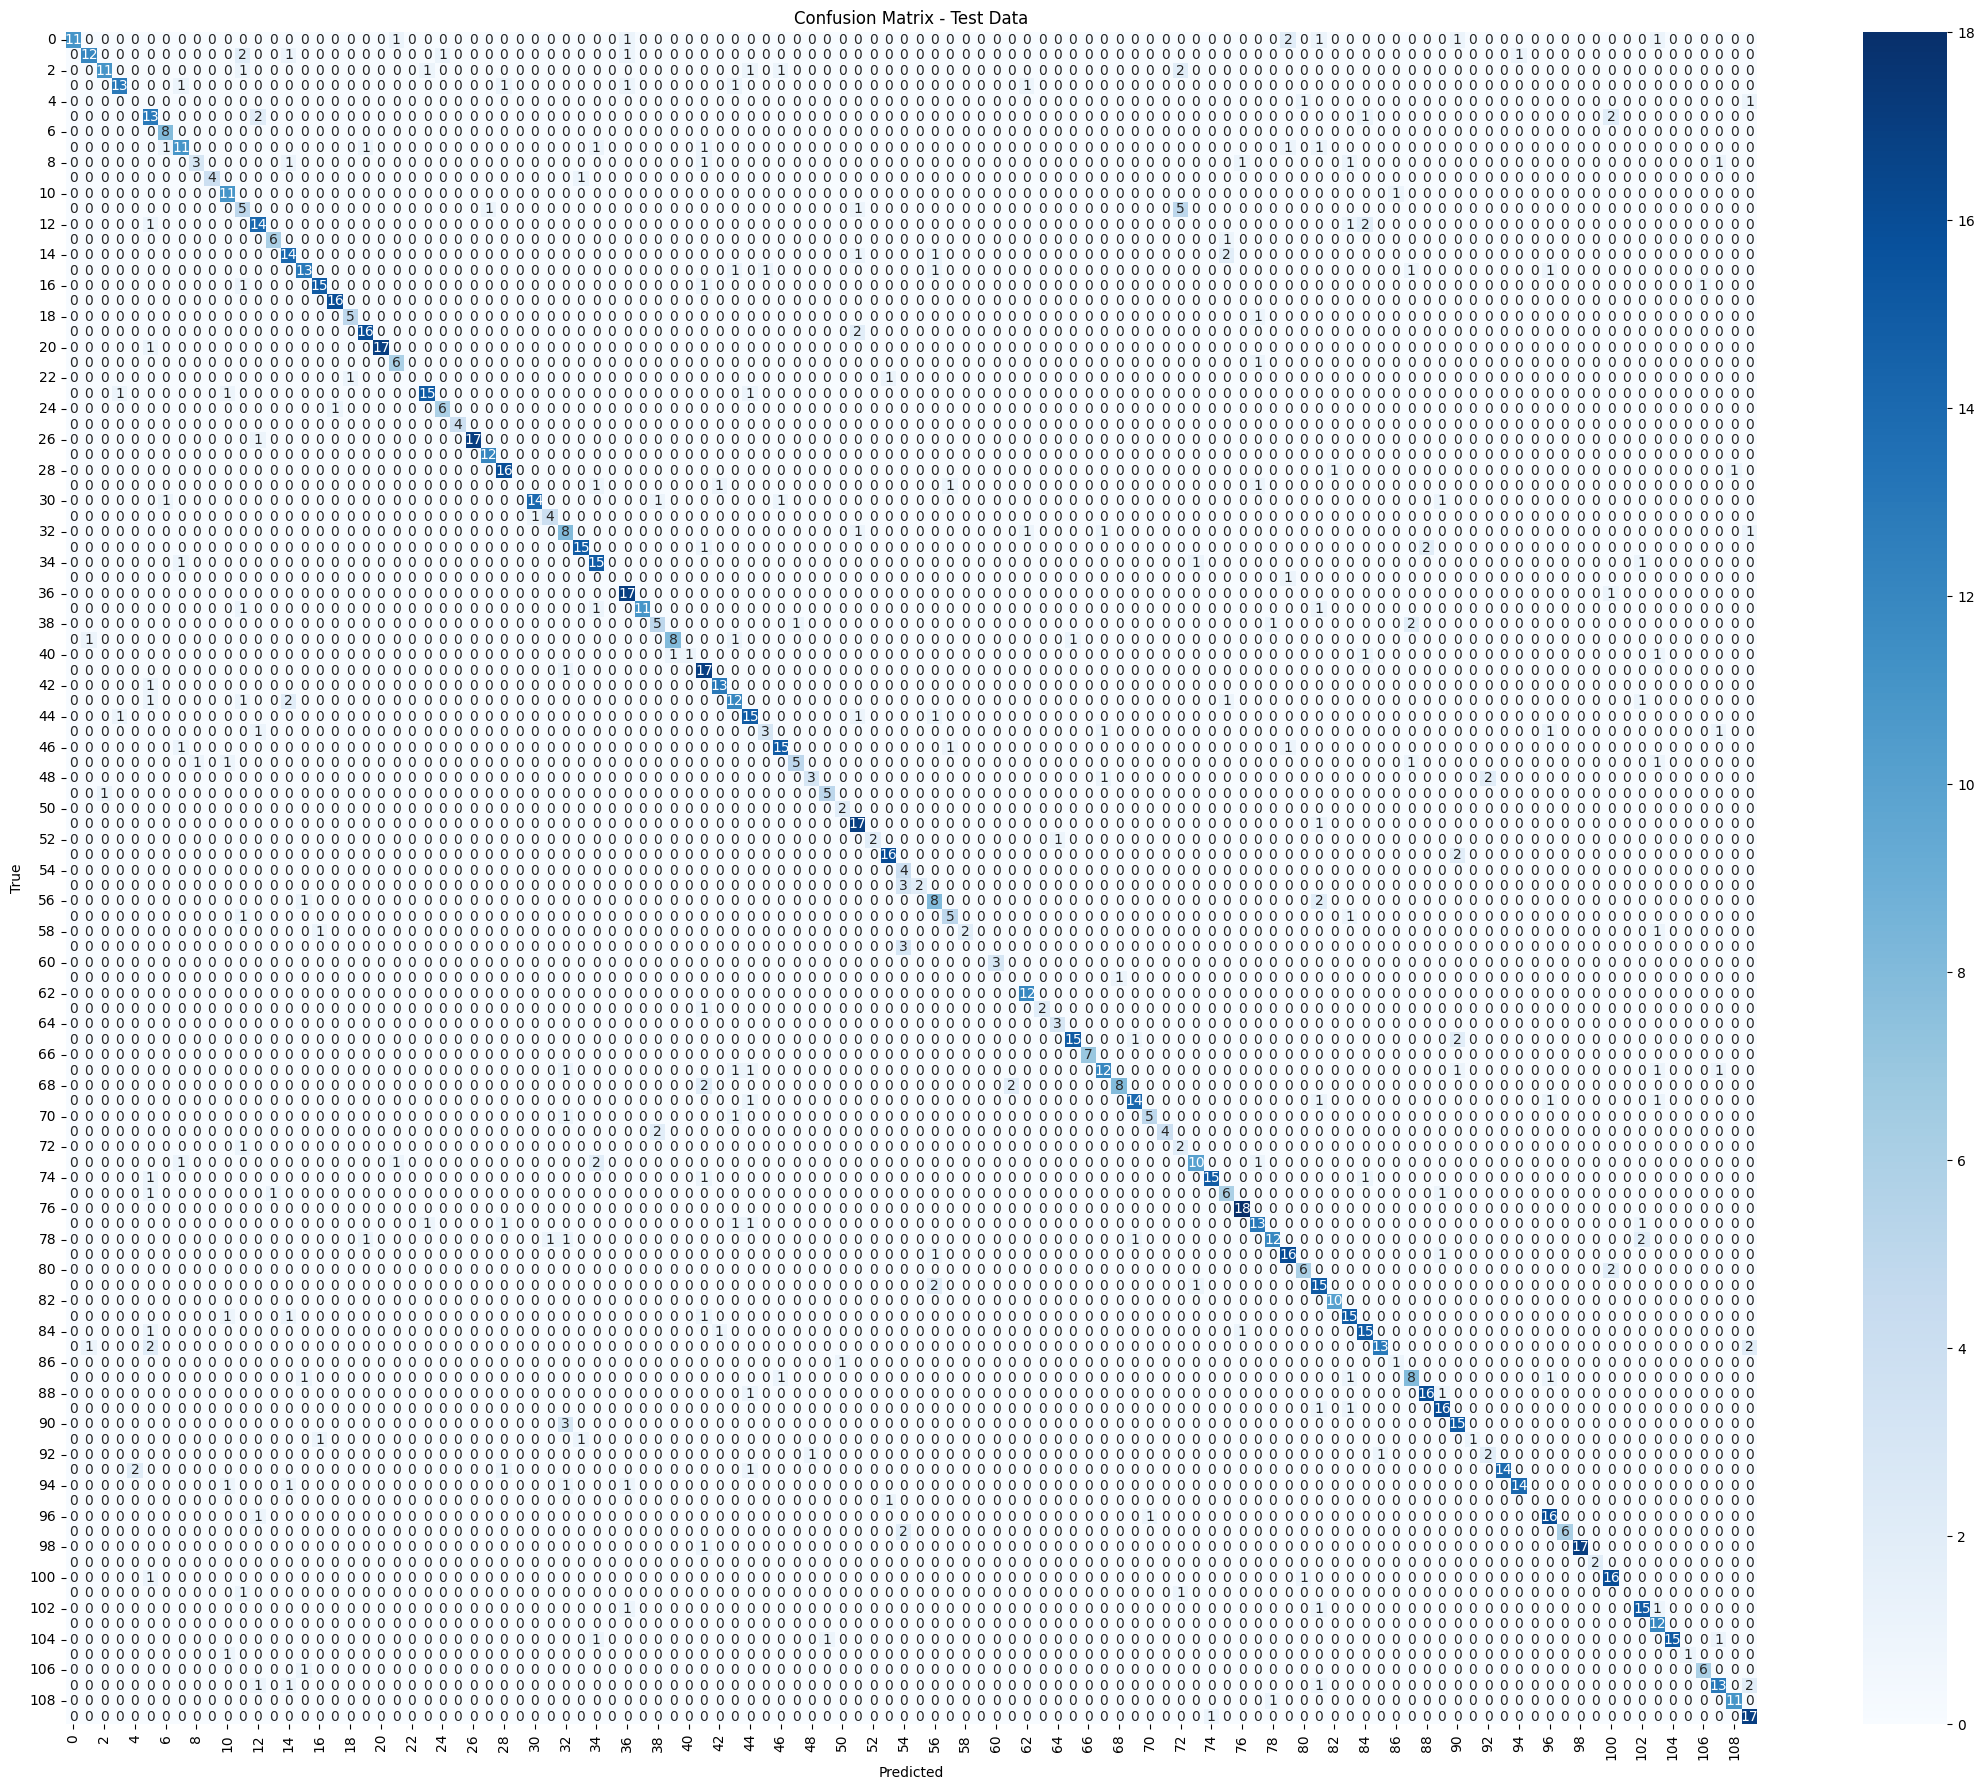

Classification Report (Test Data):


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

           0       1.00      0.61      0.76        18
           1       0.86      0.67      0.75        18
           2       0.92      0.65      0.76        17
           3       0.87      0.72      0.79        18
           4       0.00      0.00      0.00         2
           5       0.57      0.72      0.63        18
           6       0.80      1.00      0.89         8
           7       0.73      0.65      0.69        17
           8       0.75      0.38      0.50         8
           9       1.00      0.80      0.89         5
          10       0.69      0.92      0.79        12
          11       0.36      0.42      0.38        12
          12       0.70      0.78      0.74        18
          13       0.86      0.86      0.86         7
          14       0.67      0.78      0.72        18
          15       0.81      0.72      0.76        18
          16       0.88      0.83      0.86        18
          17       0.94    

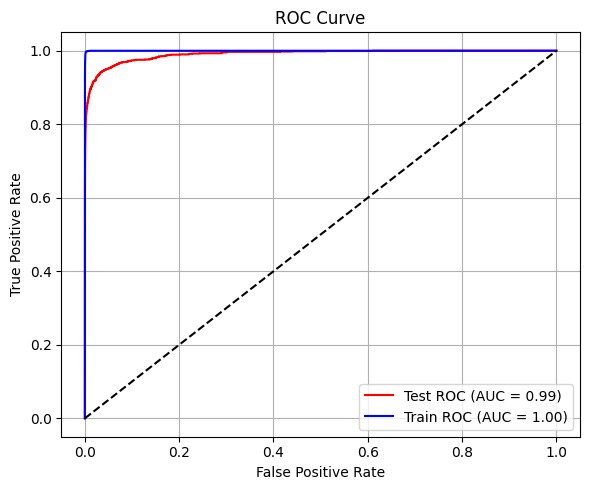

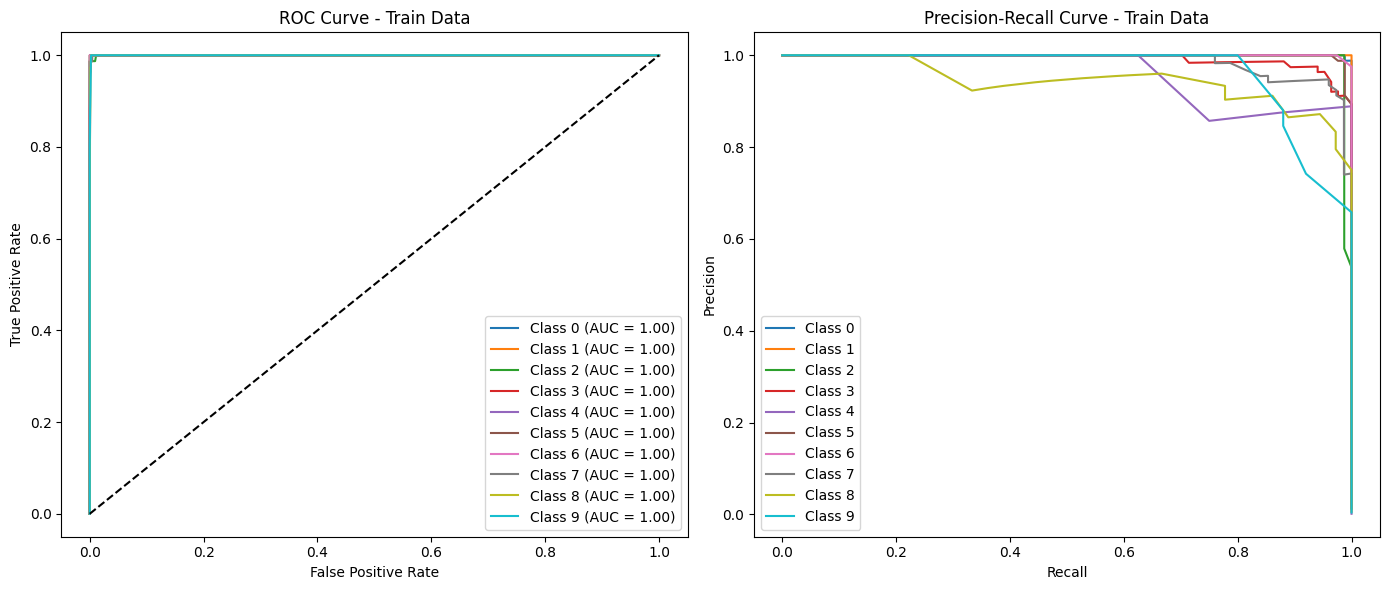

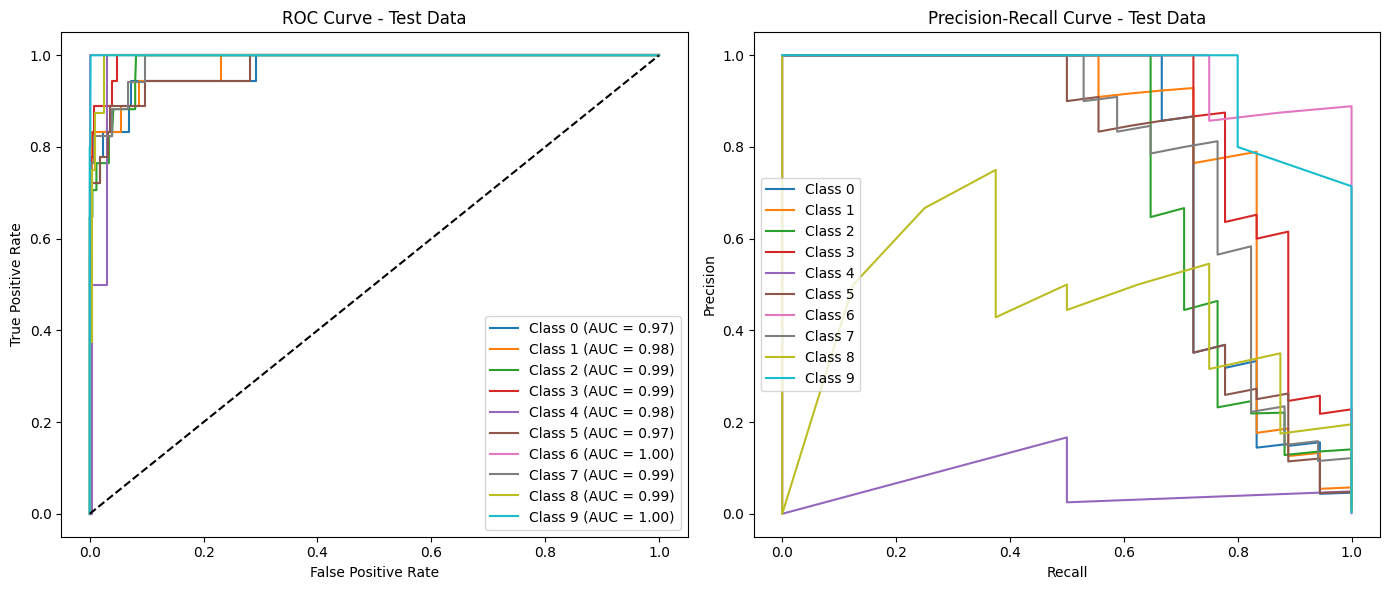

In [13]:
evaluate_model('/kaggle/input/cnn-rnn-hybrid/tensorflow2/default/1/hybrid_model_2.h5')

## Discussion and Conclusion

### Individual Model Summary

This project tackled the problem of bird species classification using audio recordings. I explored three types of deep learning models: CNNs, RNNs, and hybrid CNN-RNN architectures. Among the CNNs, Model 4 (which included batch normalization and dropout) performed best, reaching around 75% validation accuracy. However, the hybrid Model 2, which combined convolutional layers with a bidirectional LSTM, outperformed all others with a test accuracy of 79% and a macro F1-score of 0.72. This model was able to capture both spatial and temporal patterns in bird vocalizations, which proved critical for this task.

RNN-only models didn’t perform well. The best one reached just 13% accuracy. This was expected, since the input format—2D spectrograms—wasn’t ideal for RNNs. These models are better suited for raw audio or MFCCs, which I didn’t use due to time constraints.

### CNN vs. RNN vs. Hybrid Models

The differences between the model families were clear. CNNs handled the spectrograms well and learned spatial features effectively. RNNs struggled, mostly because they weren’t given the kind of sequential input they’re designed for. The hybrid models, especially the second one, were able to combine the strengths of both approaches and delivered the best results overall.

### What Went Well and What Didn’t

The preprocessing pipeline worked well. It handled MP3 conversion, silence trimming, normalization, and augmentation efficiently. The CNN and hybrid models trained smoothly and showed strong generalization. The ensemble models also helped stabilize predictions.

On the other hand, the RNN models underperformed, and class imbalance remained a challenge. Some species had very few samples, which hurt recall and precision for those classes. I also didn’t have time to experiment with alternative input formats like MFCCs or raw waveforms.

### Future Steps

There are several directions I’d like to explore next. First, I’d like to preprocess the audio into MFCCs or raw waveform segments and feed those into RNNs. That would give them a better shot at learning temporal patterns. I’d also like to address class imbalance more directly, either through class weighting or targeted augmentation. Another area worth exploring is model fusion—combining CNN and RNN outputs more explicitly. Finally, I’d like to experiment with transfer learning using pre-trained audio models like BirdNET in combintation with MIXit for better background noice reduction. 


## References

Ashraf, M., Abid, F., Ud Din, I., Rasheed, J., Yesiltepe, M., Yeo, S. F., & Ersoy, M. T. (2023). A hybrid CNN and RNN variant model for music classification. *Applied Sciences, 13*(3), 1476. https://doi.org/10.3390/app13031476 [1](https://scholarworks.sjsu.edu/)

Kumar, A. (2020, February 10). Recurrent neural nets for audio classification. *Towards Data Science*. https://towardsdatascience.com/recurrent-neural-nets-for-audio-classification-81cb62327990/ [2](https://ischool.sjsu.edu/apa-style-resources)

Raza, M., Khan, M. A., & Alghamdi, A. (2024). A novel deep learning framework for audio classification using spectrogram image features. *Procedia Computer Science, 233*, 1133–1140. https://doi.org/10.1016/j.procs.2024.04.123 [3](https://www.sjsu.edu/writingcenter/docs/handouts/APA%20Citation%20Guide-7th%20Edition-Final.pdf)

Zhou, Y. (2014). Automatic bird song recognition using machine learning algorithms (Master’s thesis, San José State University). *SJSU ScholarWorks*. https://scholarworks.sjsu.edu/cgi/viewcontent.cgi?article=2377&context=etd_projects [4](https://www.mybib.com/tools/apa-citation-generator)


**Note:** Minimal use of AI was employed to troubleshoot syntax errors in code and provide limited assistance with Markdown formatting.
